In [44]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as spl
import statsmodels.graphics.gofplots as gpl
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from arch import arch_model 

import matplotlib.pyplot as plt

# 1. Загрузка данных

In [10]:
bonds_file_names = ['/SU26205RMFS3_rates.csv', 
                 '/SU26209RMFS5_rates.csv',
                 '/SU26212RMFS9_rates.csv',
                 '/SU26215RMFS2_rates.csv', 
                 '/SU26217RMFS8_rates.csv']

bonds_names = [x[1:len('SU26209RMFS5')+1] for x in bonds_file_names]

shares_file_names = ["/SBER.ME.csv", 
                  '/GAZP.ME.csv', 
                  '/YNDX.ME.csv',
                  '/MGNT.ME.csv', 
                  '/GMKN.ME.csv',
                  '/MTSS.ME.csv', 
                  '/PIKK.ME.csv', 
                  '/AFLT.ME.csv', 
                  '/POLY.ME.csv', 
                  '/RSTI.ME.csv']

shares_names = [x[1:5] for x in shares_file_names]

currencies_file_names = ['/D_USD.csv',
                      '/D_CNY.csv']

currencies_names = [x[3:6] for x in currencies_file_names]

risks_file_names = ['/IMOEX.ME.csv',
                    '/BZ=F.csv',
                    '/RTS.csv',
                   '/JPY.csv',
                    '/EUR.csv',
                    '/GBP.csv']   

risks_names = [x.split('/')[1].split('.csv')[0] for x in risks_file_names]

bonds_folder = 'bonds'
shares_folder = 'shares'
currencies_folder = 'currencies'
risks_folder = 'risk_factors'

bonds = [bonds_folder + x for x in bonds_file_names]
shares = [shares_folder + x for x in shares_file_names]
currencies = [currencies_folder + x for x in currencies_file_names]
risks = [risks_folder + x for x in risks_file_names]
zero_bonds = risks_folder + '/zero_bonds.csv'
metals = risks_folder + '/refined_precious_metals.xlsx'

In [11]:
def load_df(bonds=bonds, bonds_names=bonds_names, 
            shares=shares, shares_names=shares_names,
            currencies=currencies, currencies_names=currencies_names,
            risks=risks, risks_names=risks_names,
            zero_bonds=zero_bonds, metals=metals):
#     Основной df
    main_df = pd.read_csv(bonds[0], index_col='<DATE>')
    main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
    main_df = main_df[[]]
    main_df.index.names = ['Date']
#     Загрузка облигаций
    for i in range(len(bonds)):
        df = pd.read_csv(bonds[i], index_col='<DATE>')
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        df = df[['<CLOSE>']].rename(columns={'<CLOSE>': bonds_names[i]})
        df.index.names = ['Date']
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка акций
    for i in range(len(shares)):
        df = pd.read_csv(shares[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': shares_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка валют
    for i in range(len(currencies)):
        df = pd.read_csv(currencies[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': currencies_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка рисков
    for i in range(len(risks)):
        df = pd.read_csv(risks[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка металлов
    df = pd.read_excel(metals, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Загрузка zero_bonds
    df = pd.read_csv(zero_bonds, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Заполнение пропусков
    main_df.fillna(method='ffill', inplace=True)
    main_df.fillna(method='backfill', inplace=True)

    return main_df

In [321]:
prices = load_df()

bonds = prices.iloc[:, 0:5]
shares = prices.iloc[:, 5:15]
currencies = prices.iloc[:, 15:17]
risk_factors = prices.iloc[:, 17:]

# 2. Описательная статистика риск-факторов

In [15]:
def plot_cor_matrix(risk_factors: pd.DataFrame) -> None:
    corr_matrix = risk_factors.corr()
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    
    sns.heatmap(corr_matrix, annot=True)
    
    plt.show()

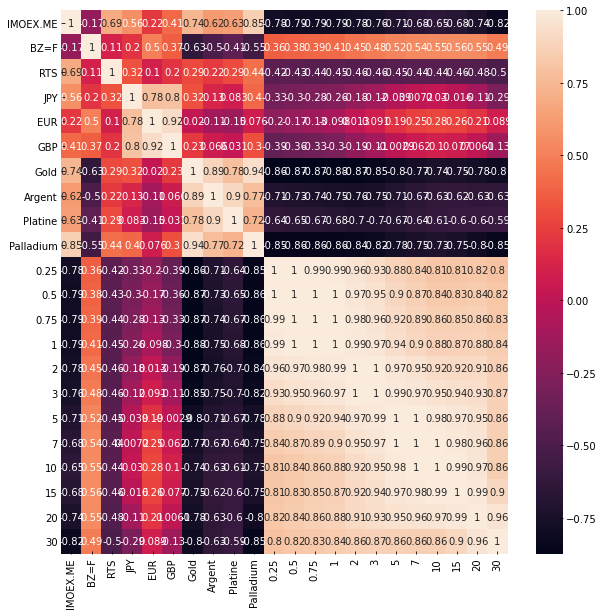

In [16]:
plot_cor_matrix(risk_factors)

In [17]:
def risk_factor_describe(risk_factor: pd.Series) -> None:
    risk_factor_name = risk_factor.name
    print(f"{'=' * 10} {risk_factor_name.upper()} {'=' * 10}")
    print(f"mean: {np.round(np.mean(risk_factor), 2)}")
    print(f"std: {np.round(np.std(risk_factor), 2)}")
    print(f"min: {np.round(np.min(risk_factor), 2)}")
    print(f"max: {np.round(np.max(risk_factor), 2)}")
    adfuller_pv = adfuller(risk_factor)[1]
    print(
        f"The Augmented Dickey-Fuller test, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    risk_factor_change = risk_factor.pct_change().iloc[1:]
    adfuller_pv = adfuller(risk_factor_change)[1]
    print(
        f"The Augmented Dickey-Fuller test for pct change, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    
    fig = plt.figure(figsize=(15, 15))
    
    ax = plt.subplot(511)
    sns.lineplot(x=risk_factor.index, y=risk_factor, ax=ax)
    plt.title('Price')
    
    ax = plt.subplot(512)
    sns.lineplot(x=risk_factor_change.index, y=risk_factor_change, ax=ax)
    plt.title('Price percent change')
    
    ax = plt.subplot(525)
    spl.plot_acf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(526)
    spl.plot_pacf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(527)
    normal_dist = gpl.ProbPlot(risk_factor_change, fit=True)
    normal_dist.qqplot(line='r', ax=ax)
    plt.title('Q-Q')
    
    ax = plt.subplot(528)
    normal_dist.ppplot(line='45', ax=ax)
    plt.title('P-P')
    
    ax = plt.subplot(529)
    normal_dist.probplot(line='r', ax=ax)
    plt.title('Prob')
    
    ax = plt.subplot(5, 2, 10)
    sns.distplot(risk_factor_change, ax=ax)
    plt.title('Distribution')
    
    plt.tight_layout()
    plt.show()

========== IMOEX.ME ==========
mean: 2478.9
std: 360.04
min: 1817.82
max: 3289.02
The Augmented Dickey-Fuller test, p-value: 0.834159761976963, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.328184642540245e-25, series is stationary


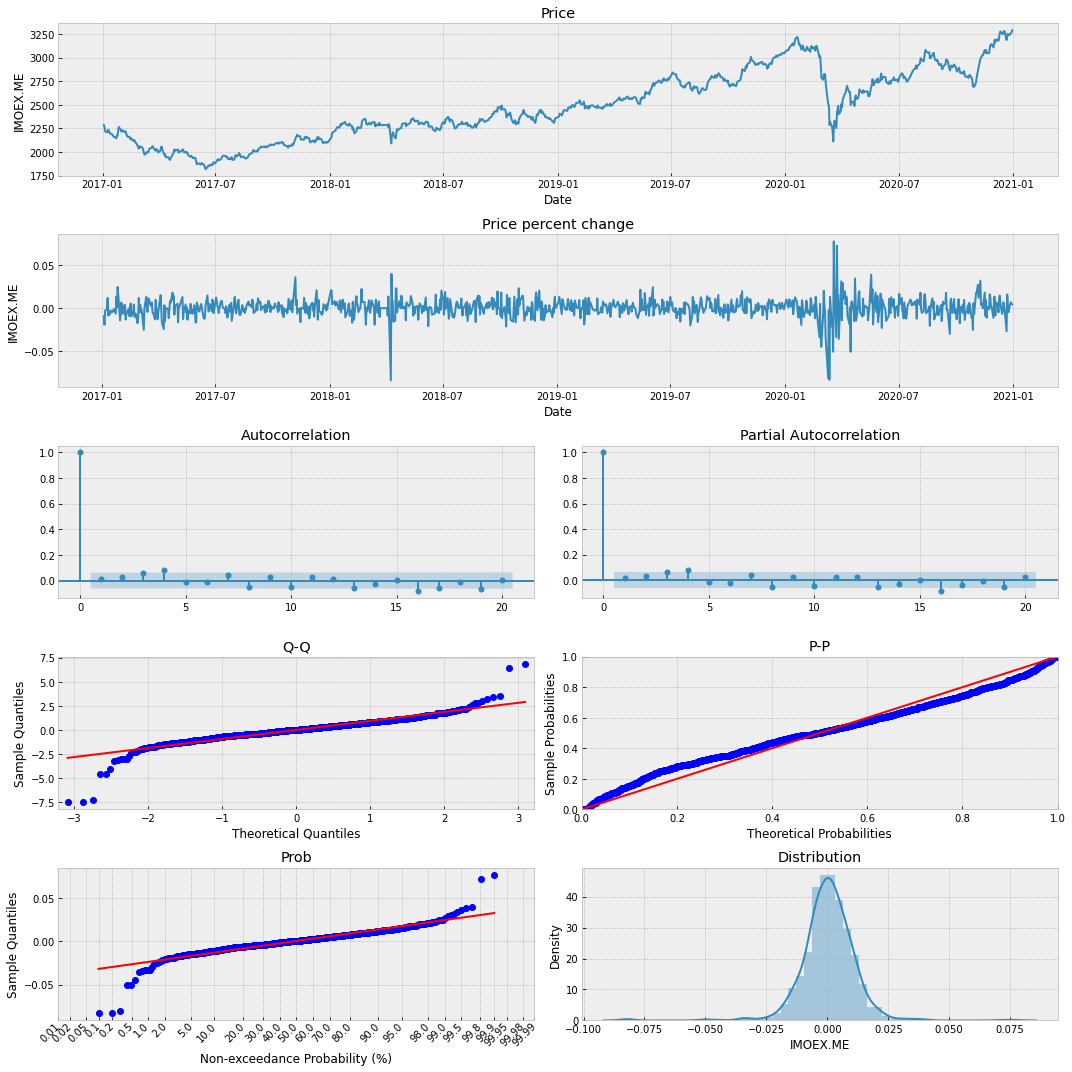

========== BZ=F ==========
mean: 58.54
std: 12.76
min: 19.33
max: 86.29
The Augmented Dickey-Fuller test, p-value: 0.2955877791601661, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.6467457927721206e-07, series is stationary


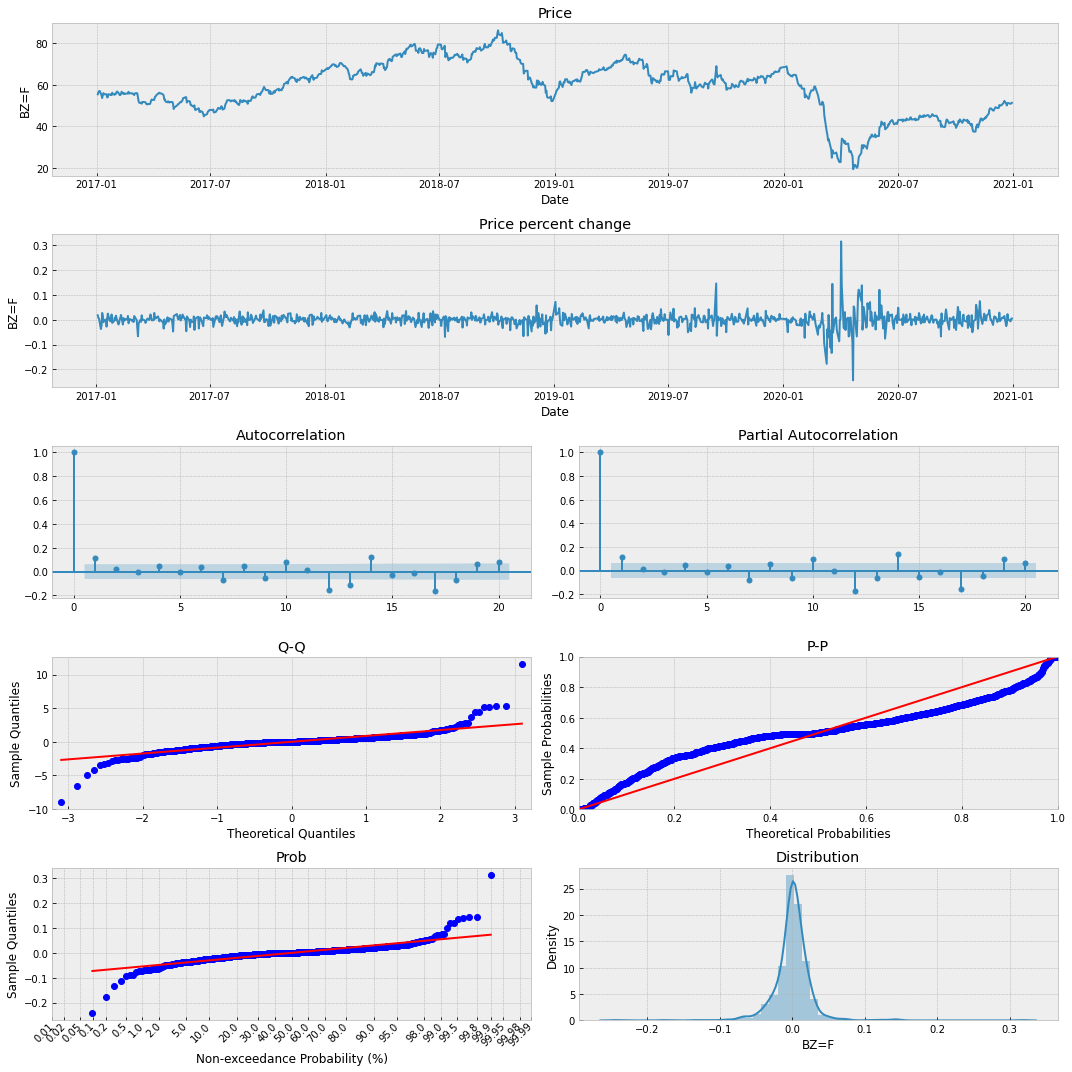

========== RTS ==========
mean: 1208.12
std: 133.8
min: 832.26
max: 1646.6
The Augmented Dickey-Fuller test, p-value: 0.27248824644357417, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.1400213521700852e-17, series is stationary


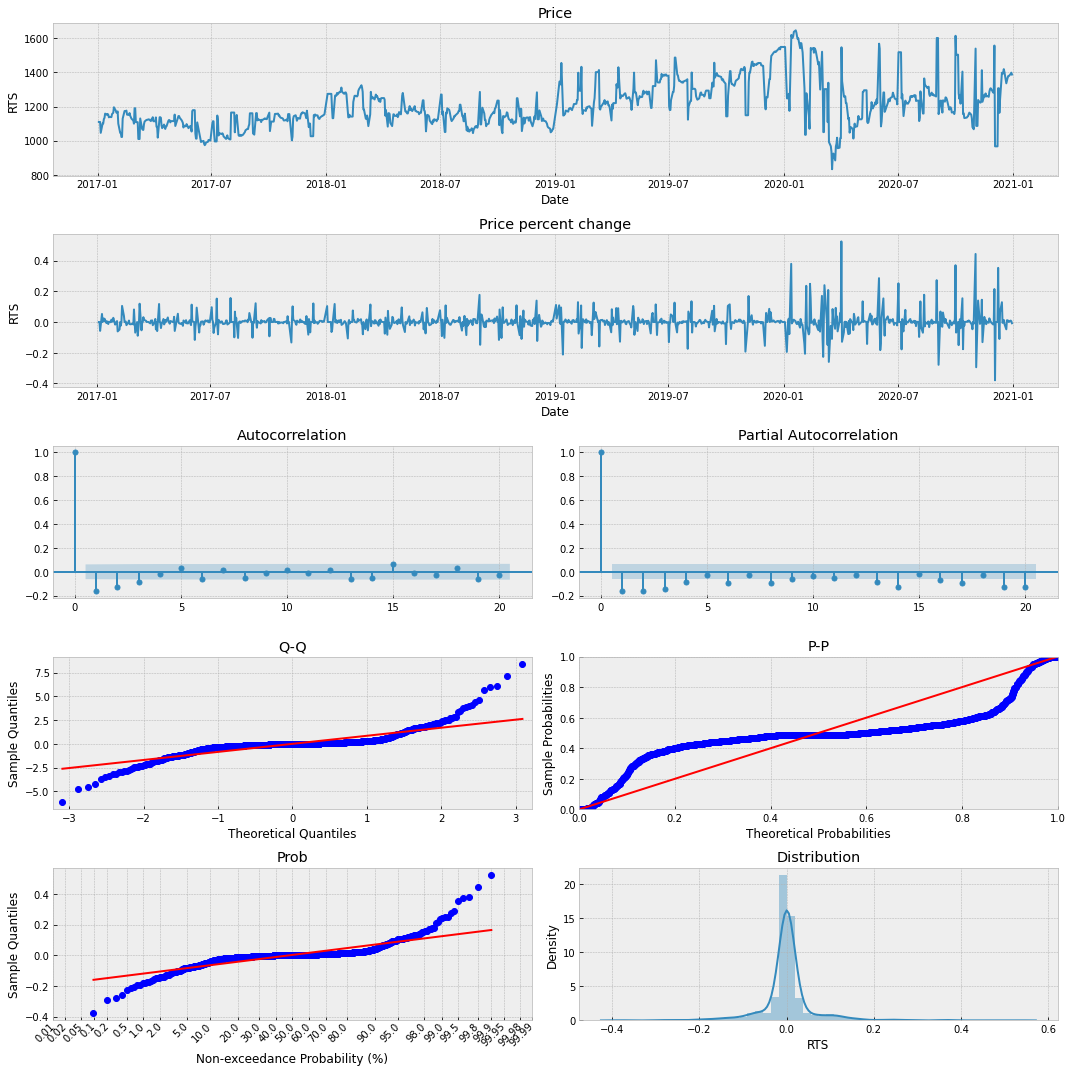

========== JPY ==========
mean: 0.56
std: 0.03
min: 0.5
max: 0.64
The Augmented Dickey-Fuller test, p-value: 0.2123112156786029, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.3168545365102758e-25, series is stationary


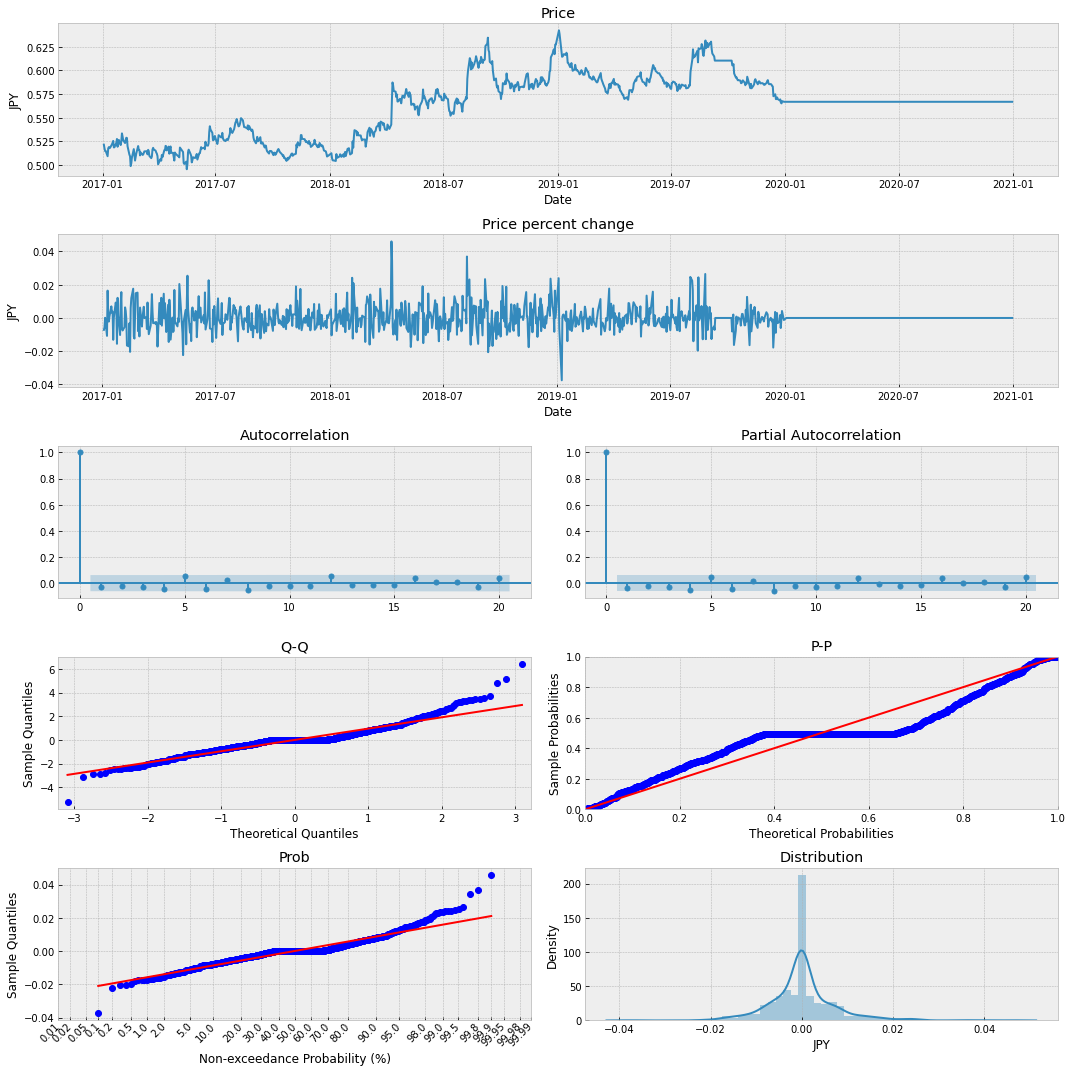

========== EUR ==========
mean: 70.47
std: 4.0
min: 59.57
max: 81.81
The Augmented Dickey-Fuller test, p-value: 0.24174034466134509, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


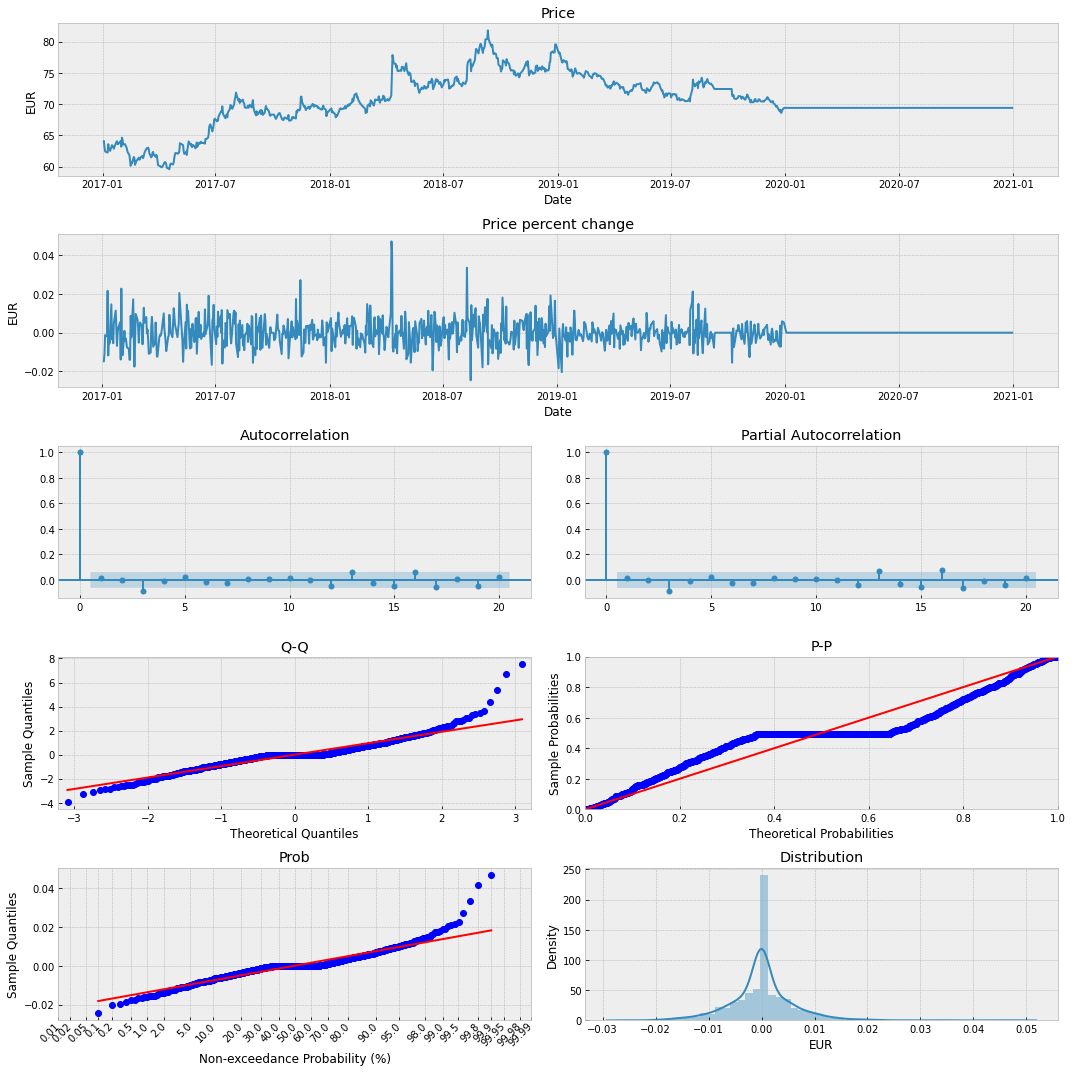

========== GBP ==========
mean: 80.67
std: 4.09
min: 69.6
max: 91.88
The Augmented Dickey-Fuller test, p-value: 0.15797404042580832, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


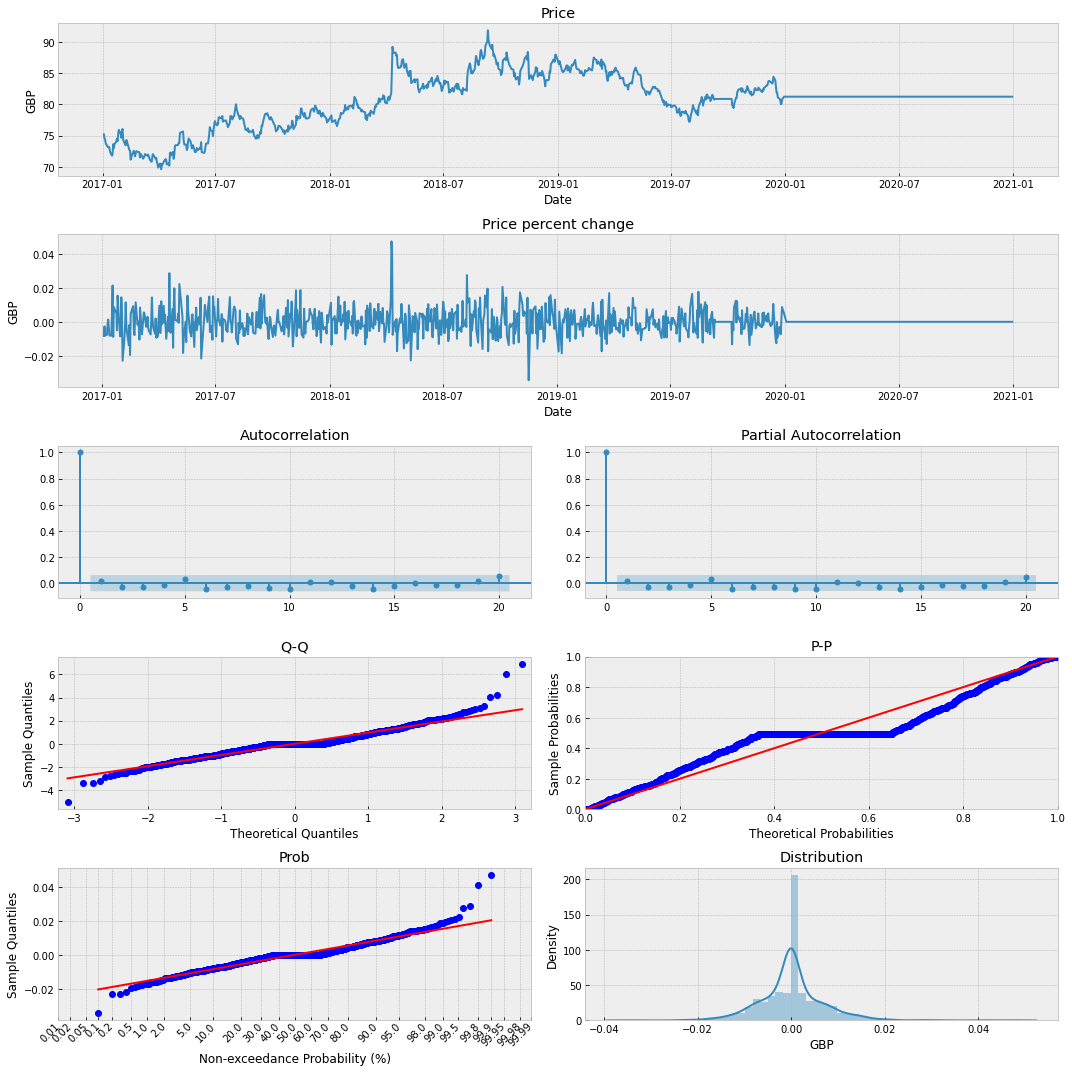

========== GOLD ==========
mean: 2983.32
std: 746.72
min: 2232.16
max: 4887.7
The Augmented Dickey-Fuller test, p-value: 0.9707079832456991, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


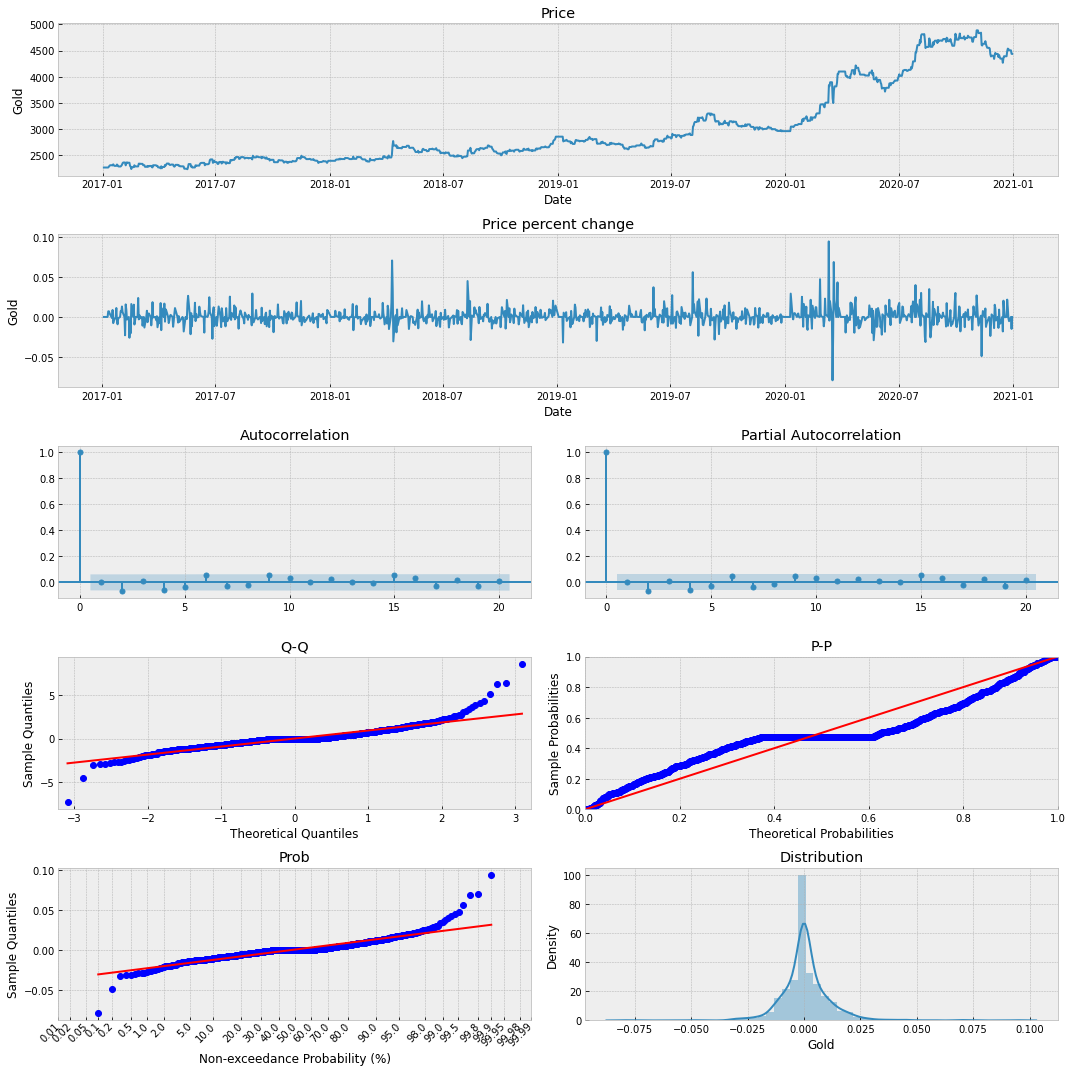

========== ARGENT ==========
mean: 36.29
std: 9.17
min: 29.51
max: 68.34
The Augmented Dickey-Fuller test, p-value: 0.943344377504336, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 6.698866653314366e-11, series is stationary


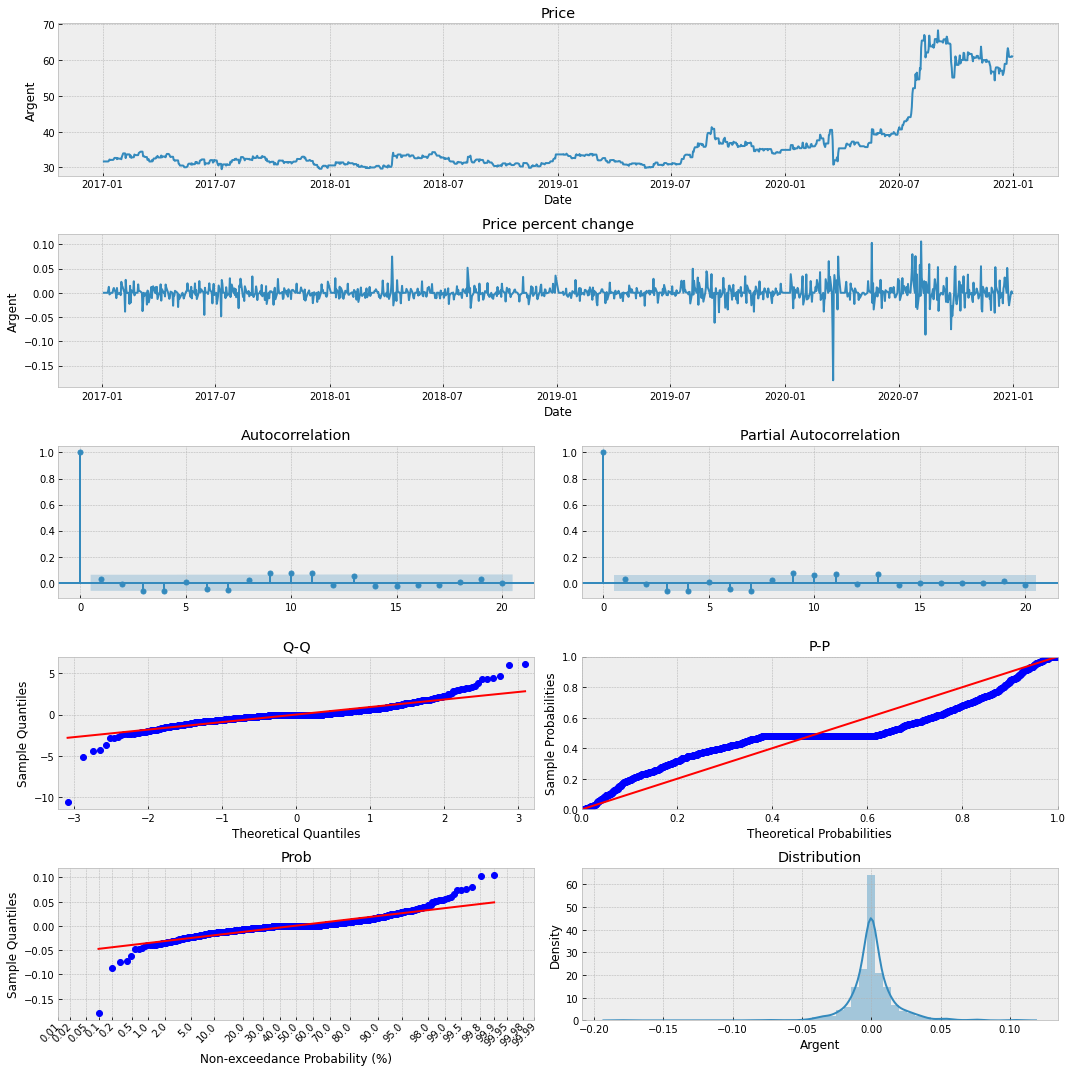

========== PLATINE ==========
mean: 1848.12
std: 170.84
min: 1522.76
max: 2473.81
The Augmented Dickey-Fuller test, p-value: 0.9508714109023069, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.274893365113512e-27, series is stationary


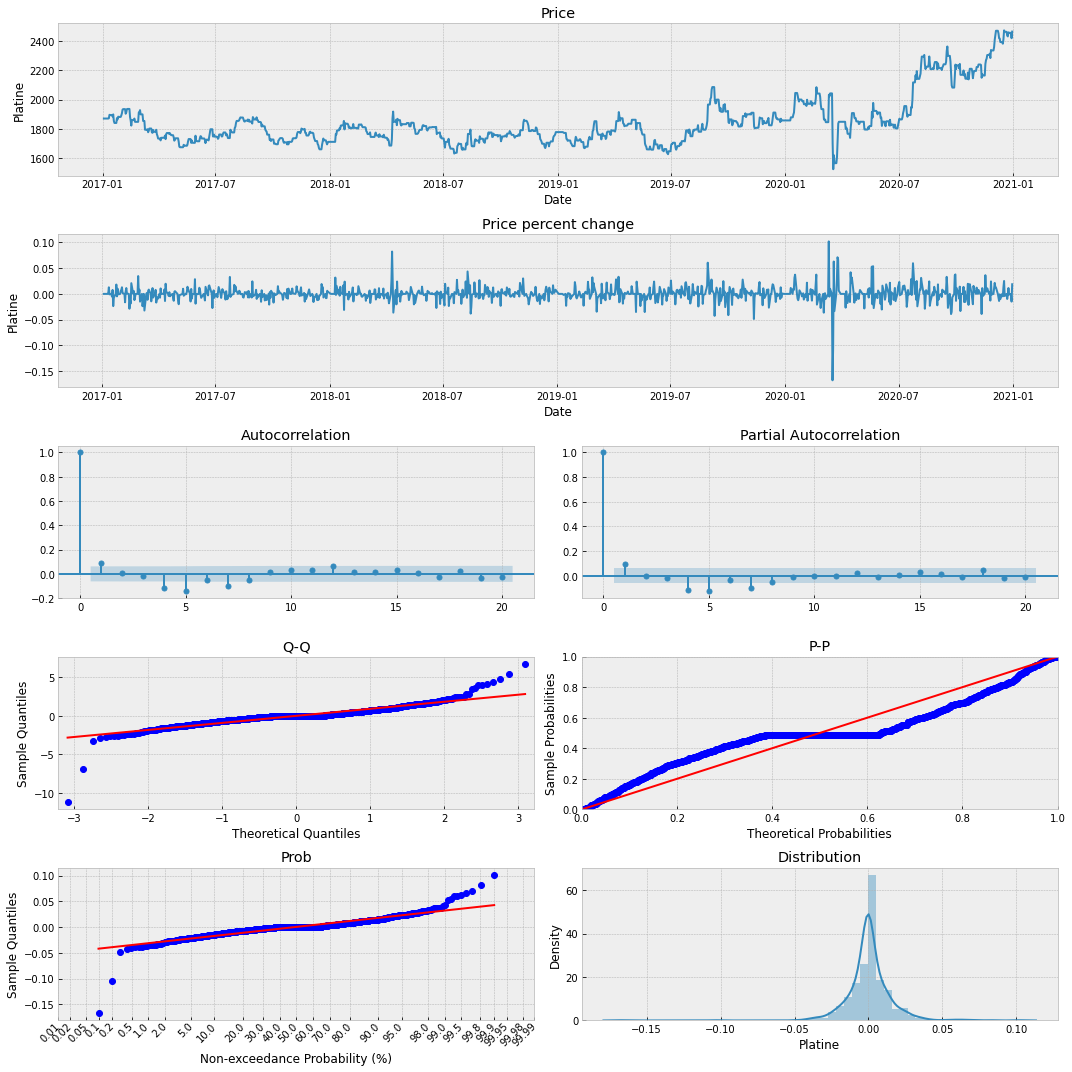

========== PALLADIUM ==========
mean: 2999.15
std: 1393.67
min: 1379.06
max: 6098.86
The Augmented Dickey-Fuller test, p-value: 0.9819060821375515, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.4455303781891075e-24, series is stationary


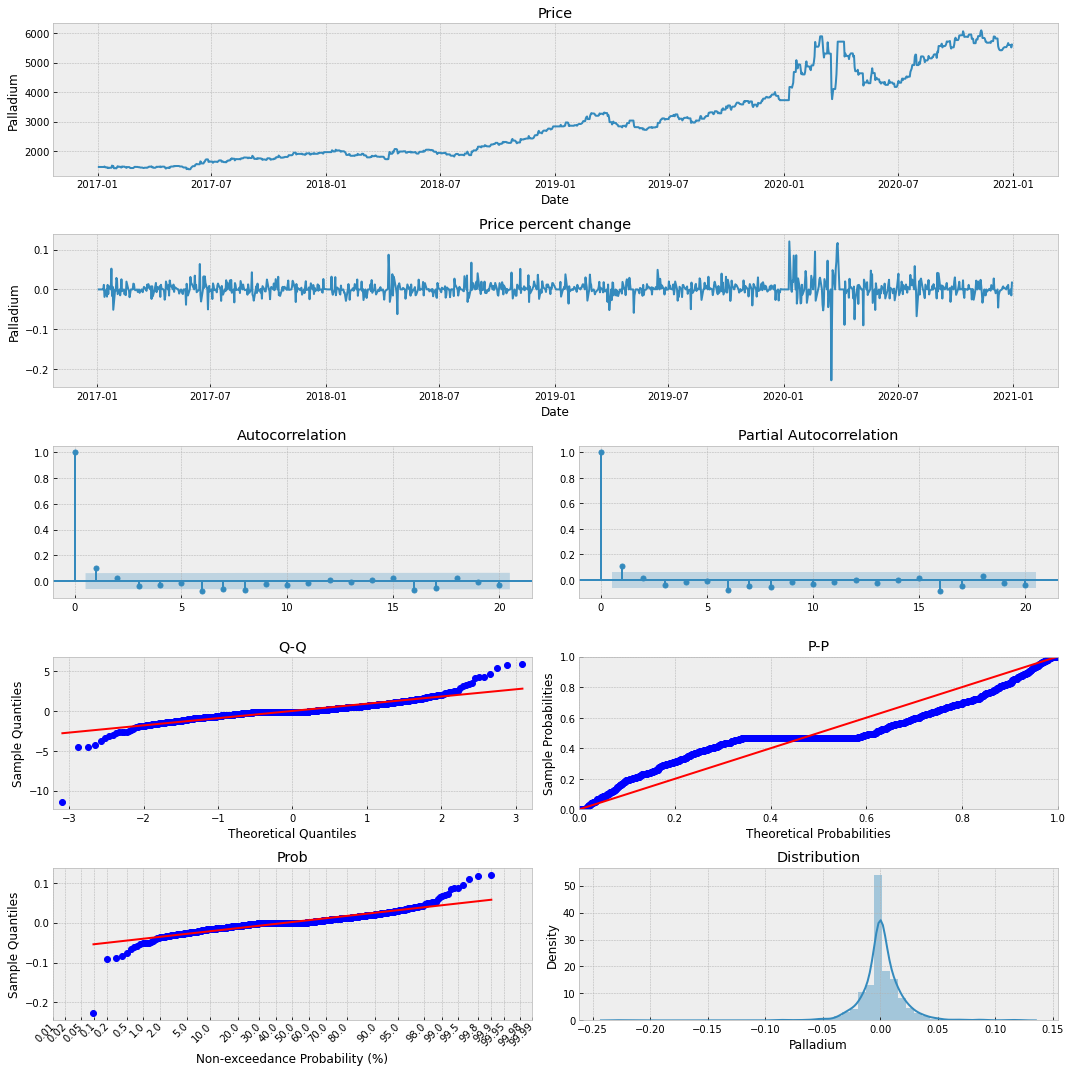

========== 0.25 ==========
mean: 6.62
std: 1.46
min: 3.68
max: 9.82
The Augmented Dickey-Fuller test, p-value: 0.9145344034994011, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


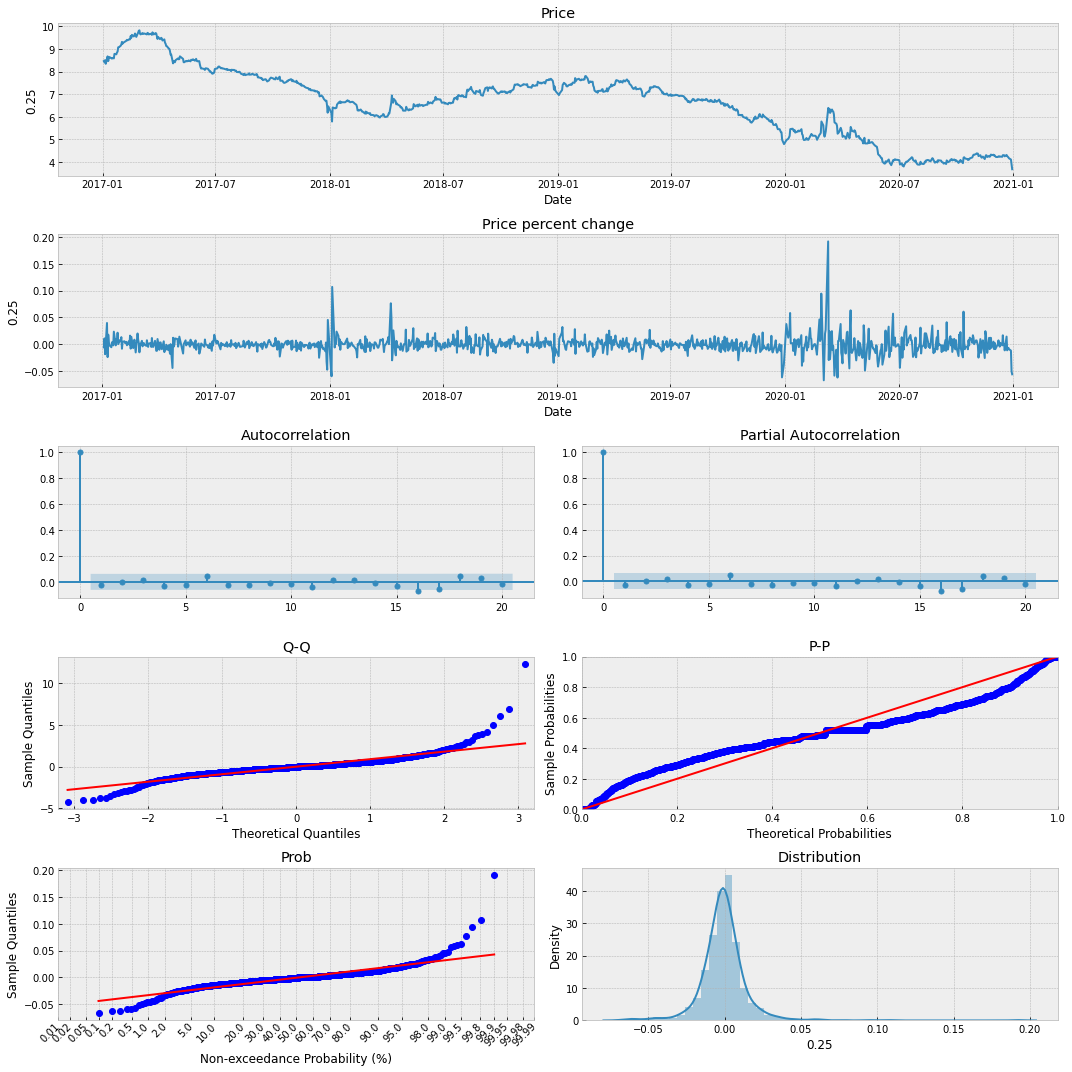

========== 0.5 ==========
mean: 6.64
std: 1.42
min: 3.87
max: 9.51
The Augmented Dickey-Fuller test, p-value: 0.9143124925299794, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


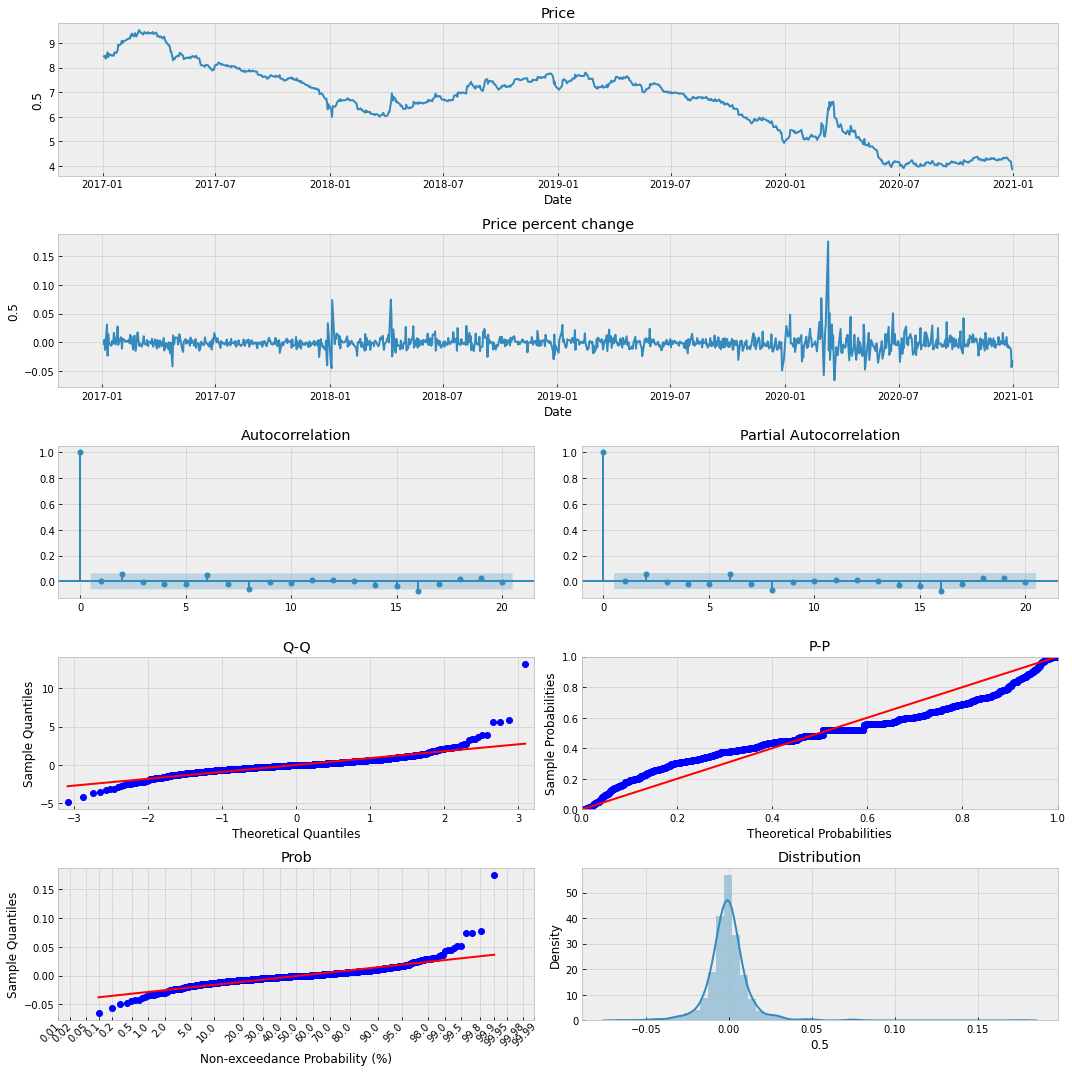

========== 0.75 ==========
mean: 6.66
std: 1.38
min: 4.02
max: 9.27
The Augmented Dickey-Fuller test, p-value: 0.9021490752383662, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.2920823550685381e-21, series is stationary


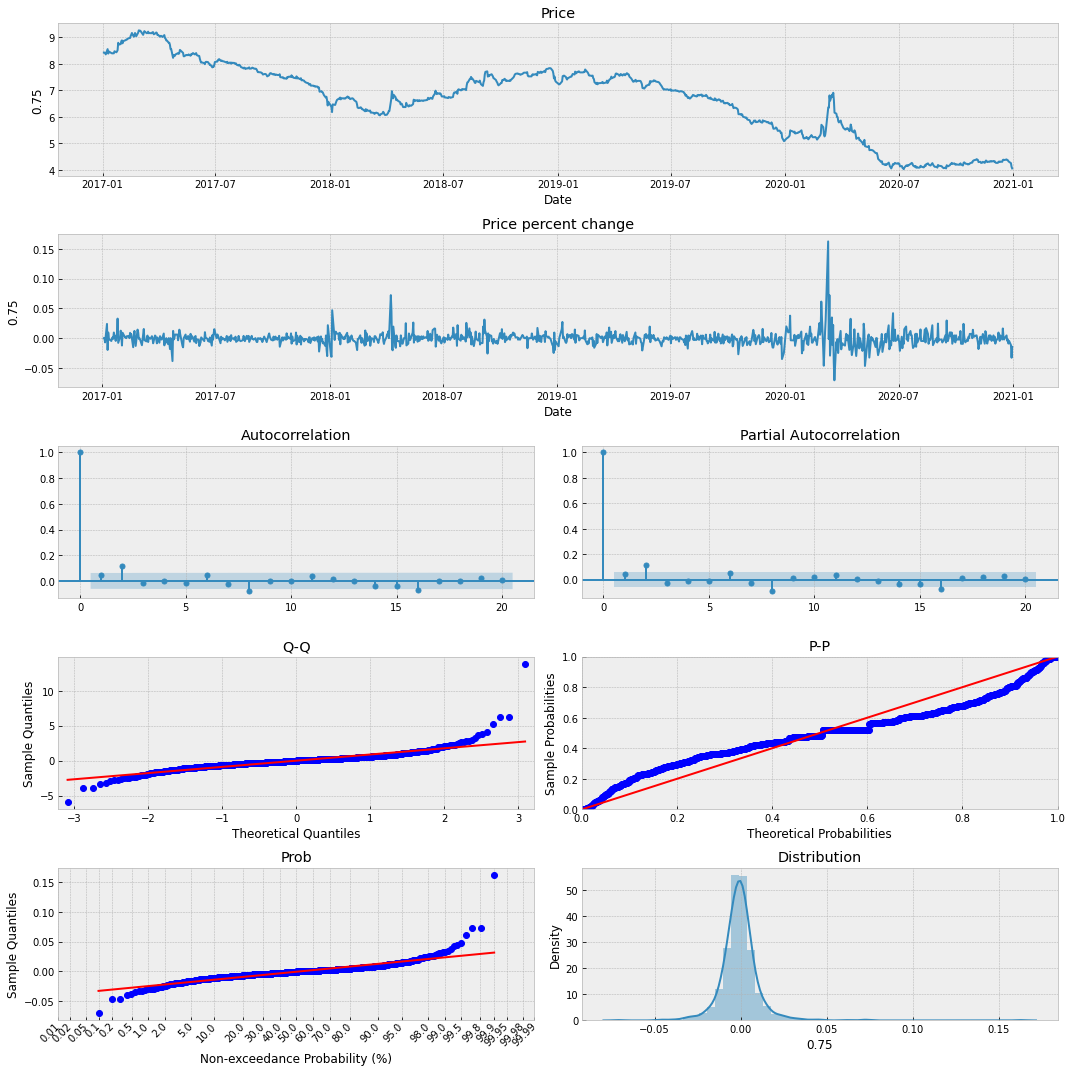

========== 1 ==========
mean: 6.69
std: 1.35
min: 4.12
max: 9.1
The Augmented Dickey-Fuller test, p-value: 0.9242625911753577, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 7.835691975403696e-22, series is stationary


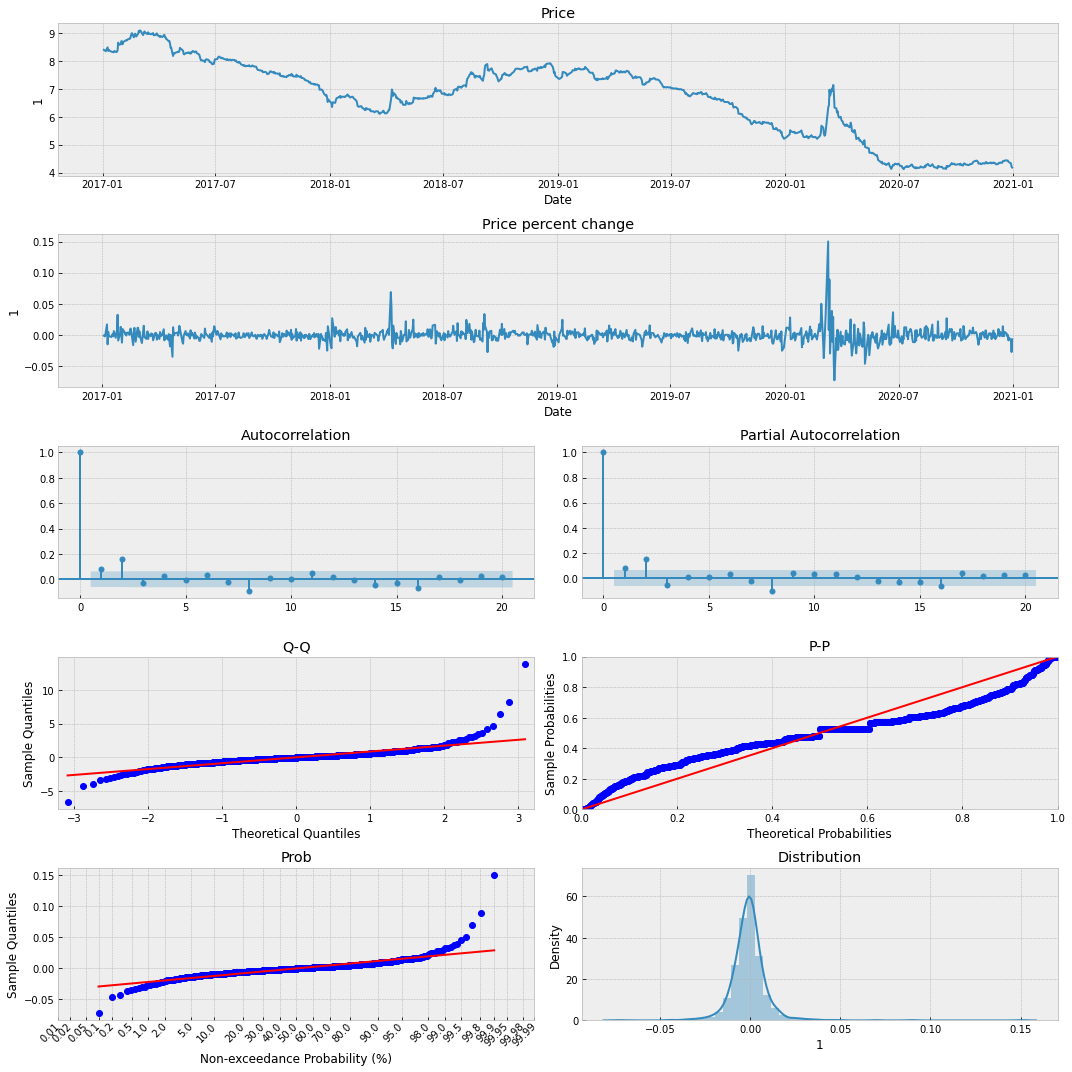

========== 2 ==========
mean: 6.8
std: 1.25
min: 4.38
max: 8.68
The Augmented Dickey-Fuller test, p-value: 0.9097458147543345, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.0934419763520733e-21, series is stationary


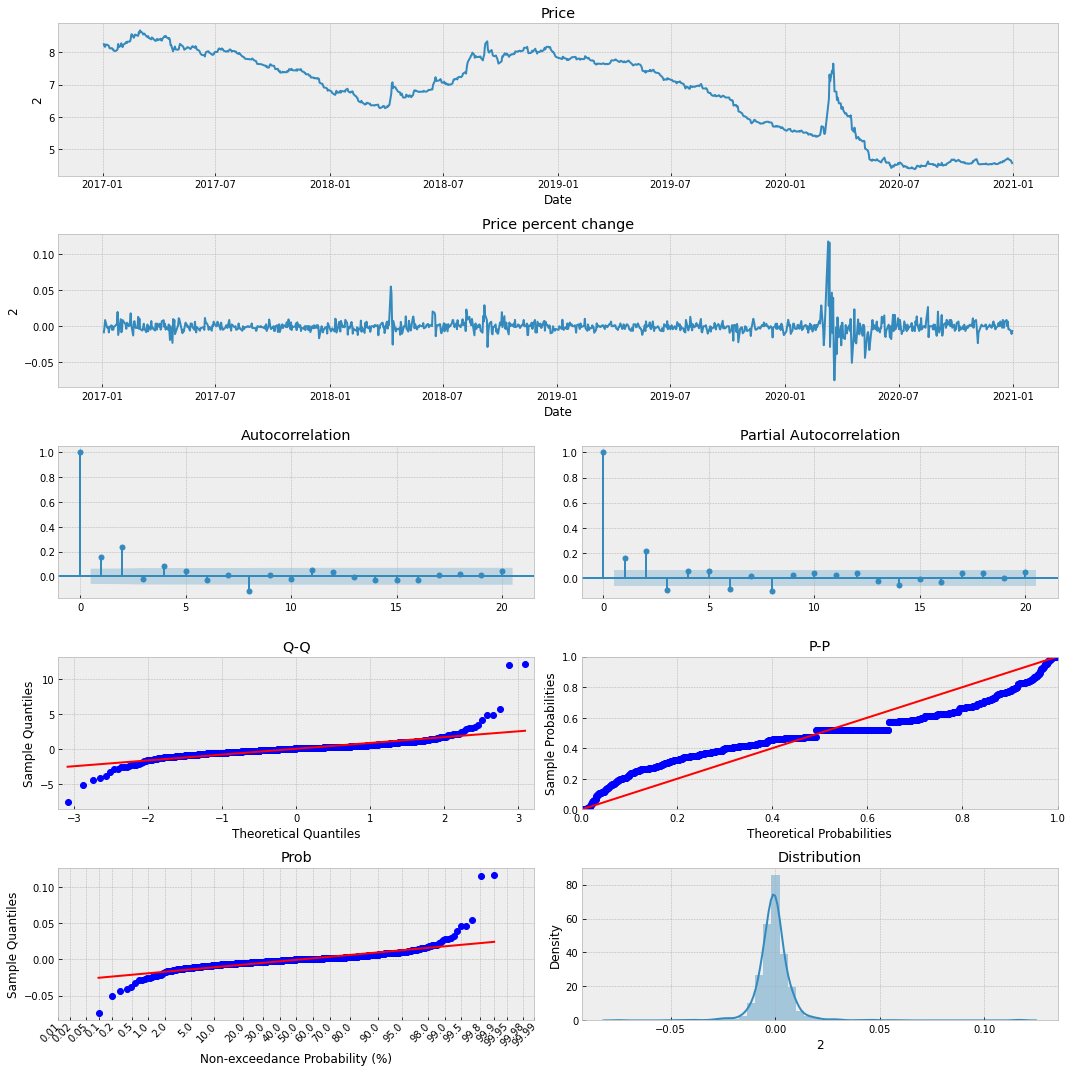

========== 3 ==========
mean: 6.9
std: 1.18
min: 4.6
max: 8.65
The Augmented Dickey-Fuller test, p-value: 0.8711439232573206, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.9097597993307798e-20, series is stationary


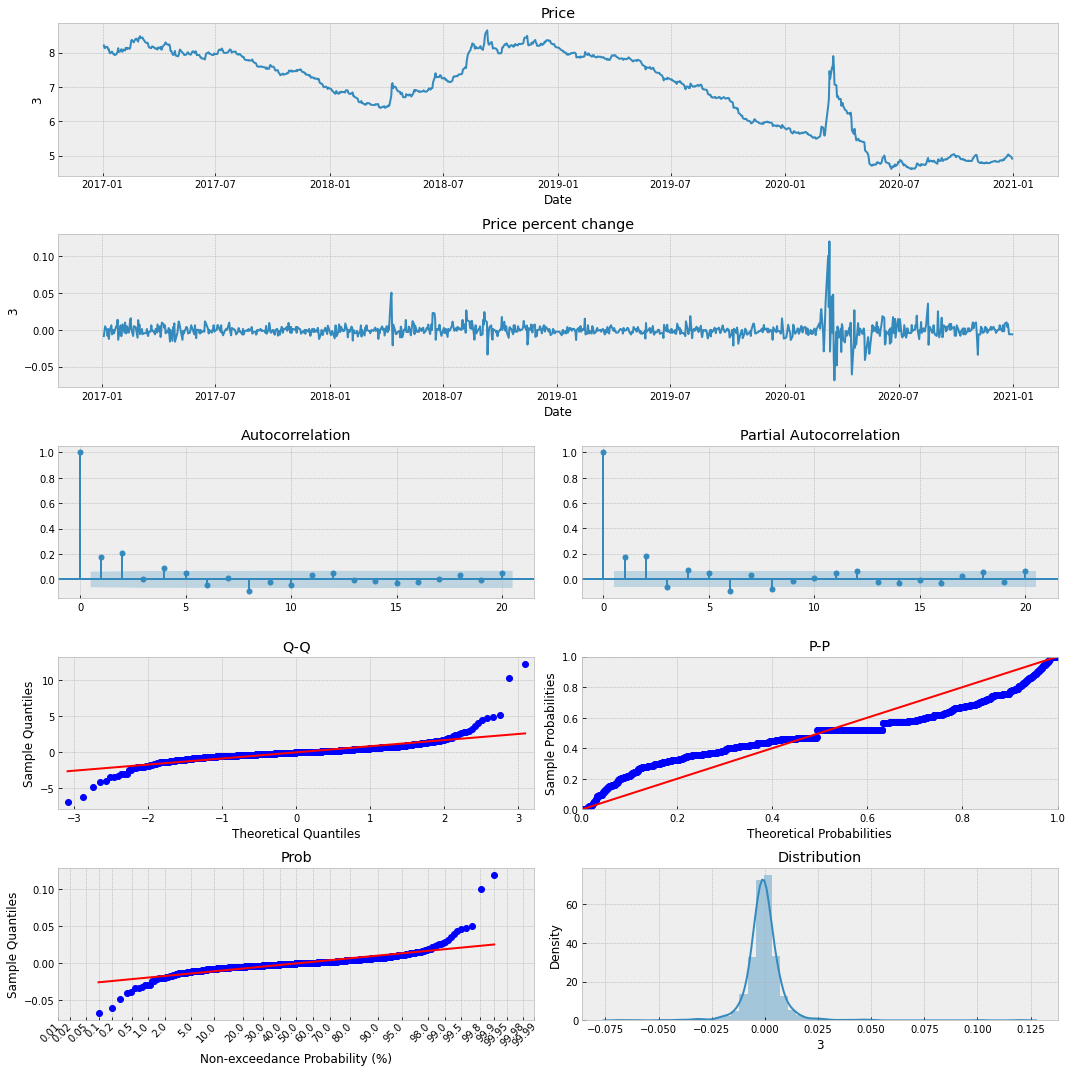

========== 5 ==========
mean: 7.09
std: 1.06
min: 4.95
max: 9.02
The Augmented Dickey-Fuller test, p-value: 0.7514487725858088, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.385770963559836e-14, series is stationary


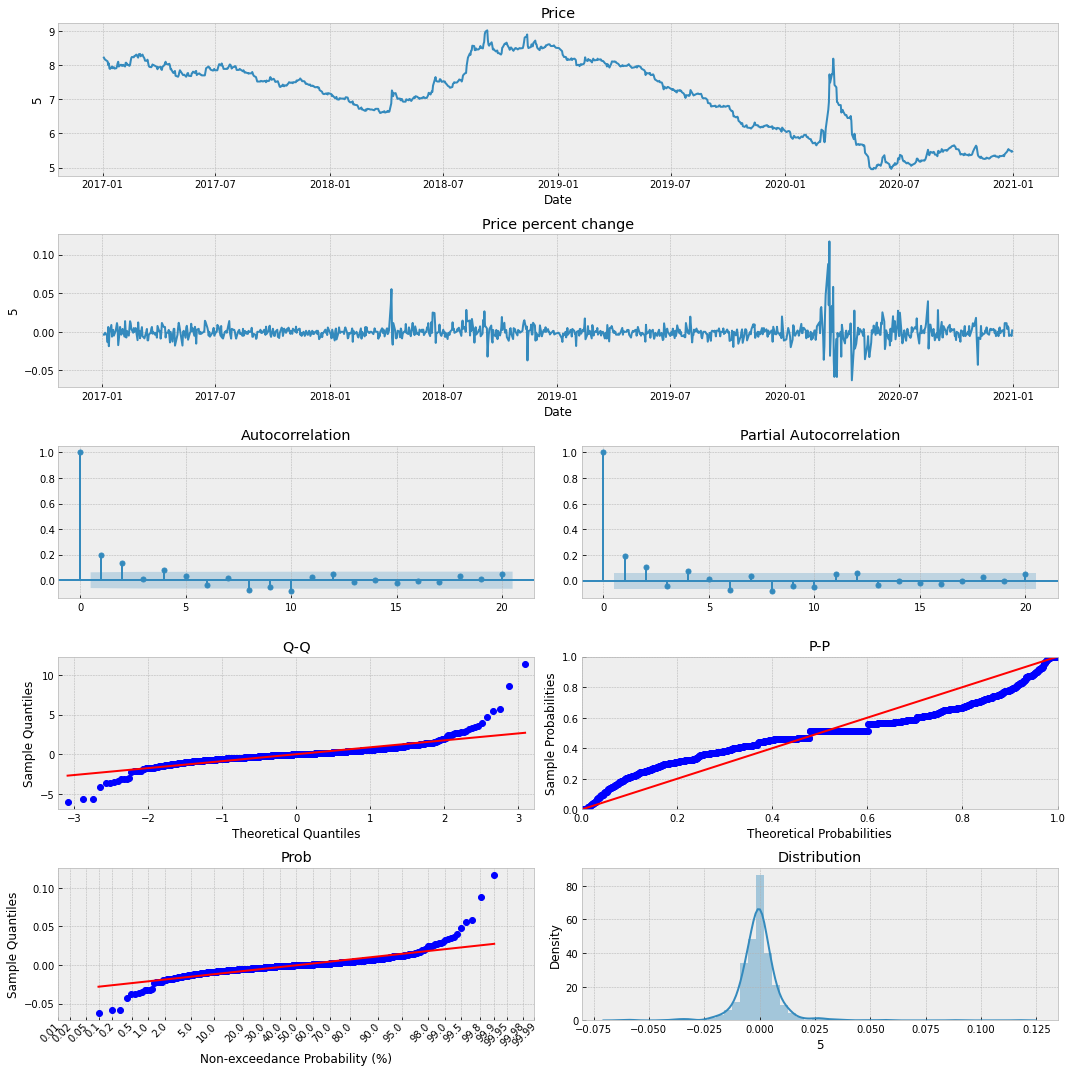

========== 7 ==========
mean: 7.24
std: 0.97
min: 5.22
max: 9.19
The Augmented Dickey-Fuller test, p-value: 0.7010514948984186, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.123899804557139e-15, series is stationary


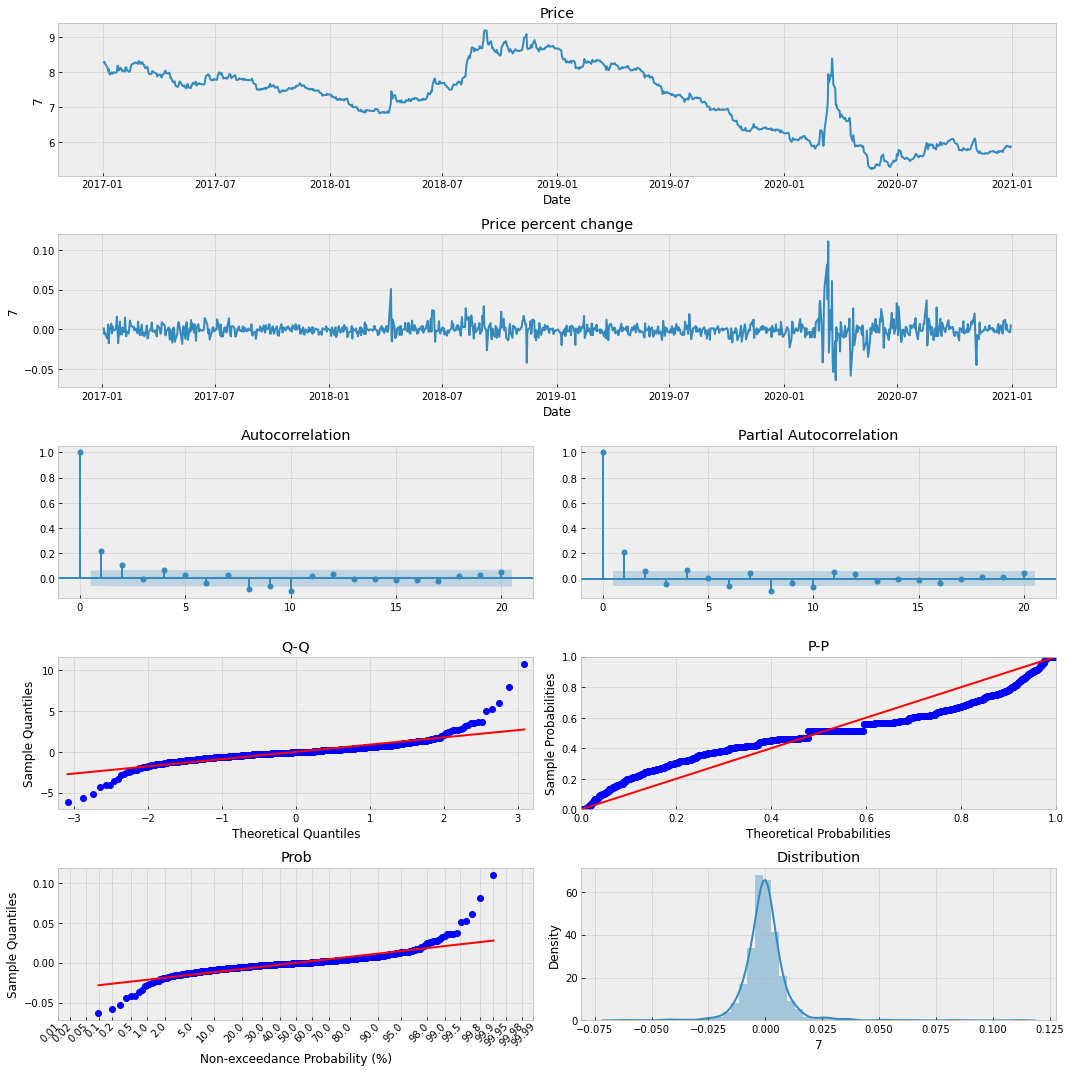

========== 10 ==========
mean: 7.43
std: 0.88
min: 5.59
max: 9.29
The Augmented Dickey-Fuller test, p-value: 0.6629083396090494, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.5376638081804764e-17, series is stationary


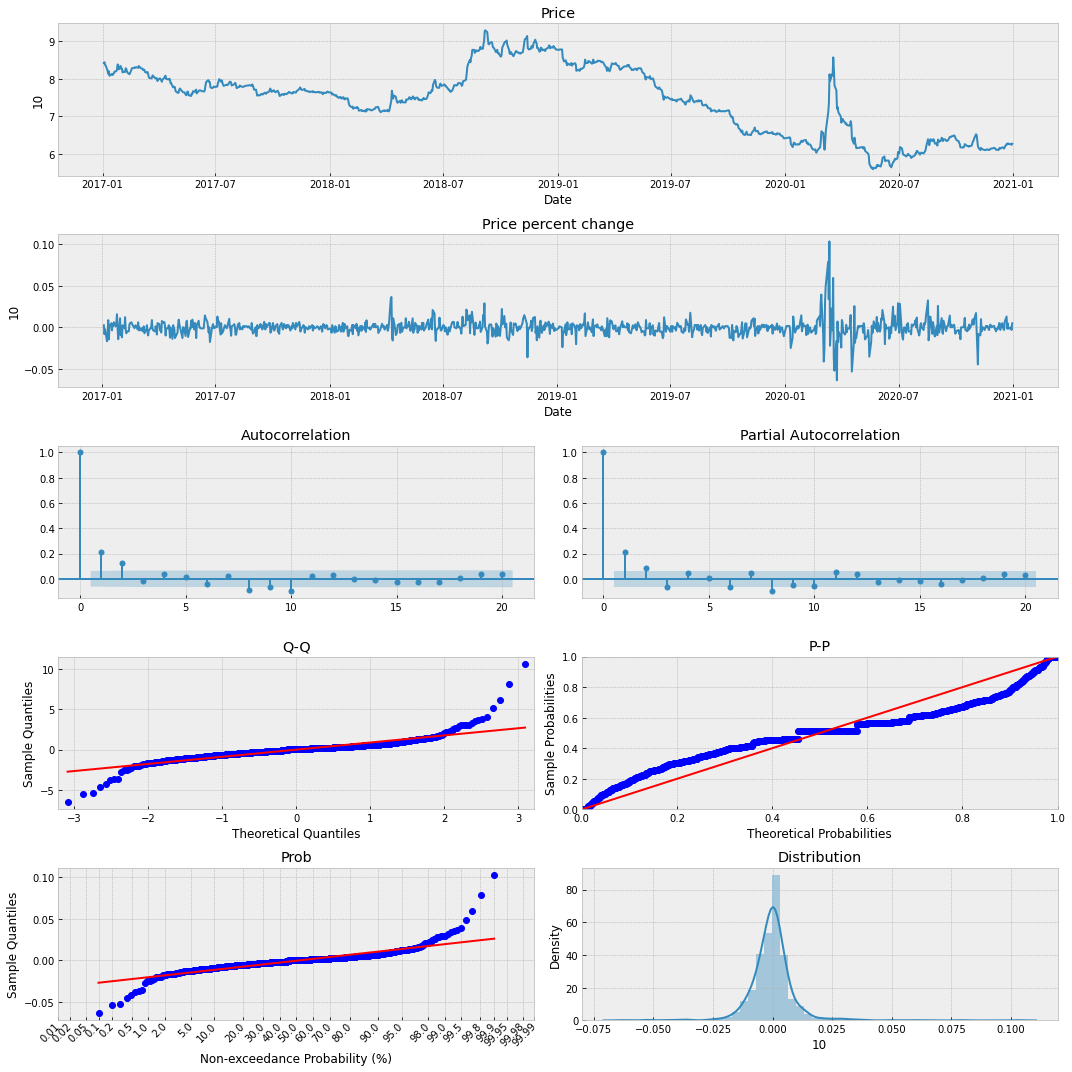

========== 15 ==========
mean: 7.66
std: 0.81
min: 5.97
max: 9.26
The Augmented Dickey-Fuller test, p-value: 0.6139933089641005, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.2880937625304694e-17, series is stationary


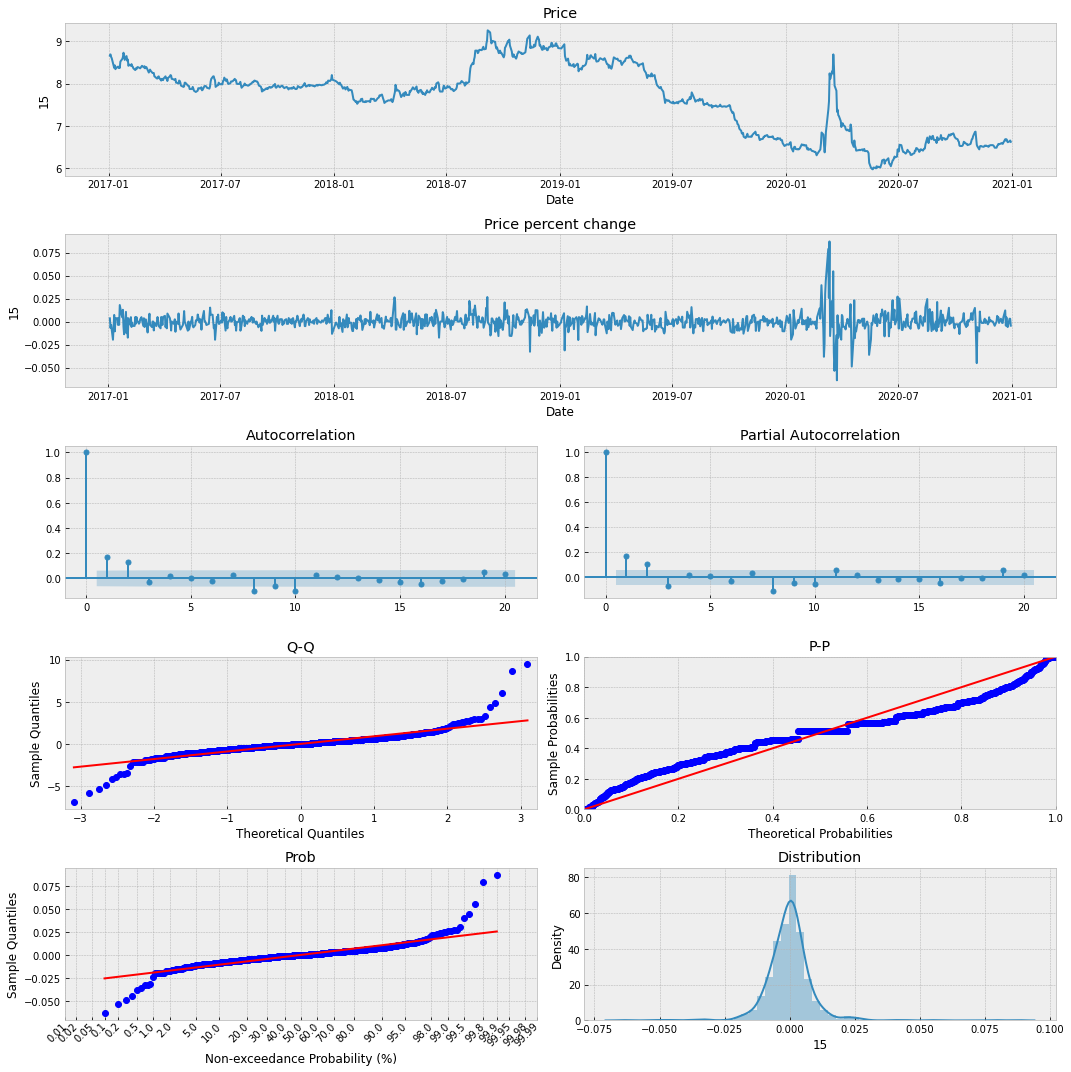

========== 20 ==========
mean: 7.84
std: 0.79
min: 6.17
max: 9.2
The Augmented Dickey-Fuller test, p-value: 0.6015415550468184, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 6.250820276208377e-18, series is stationary


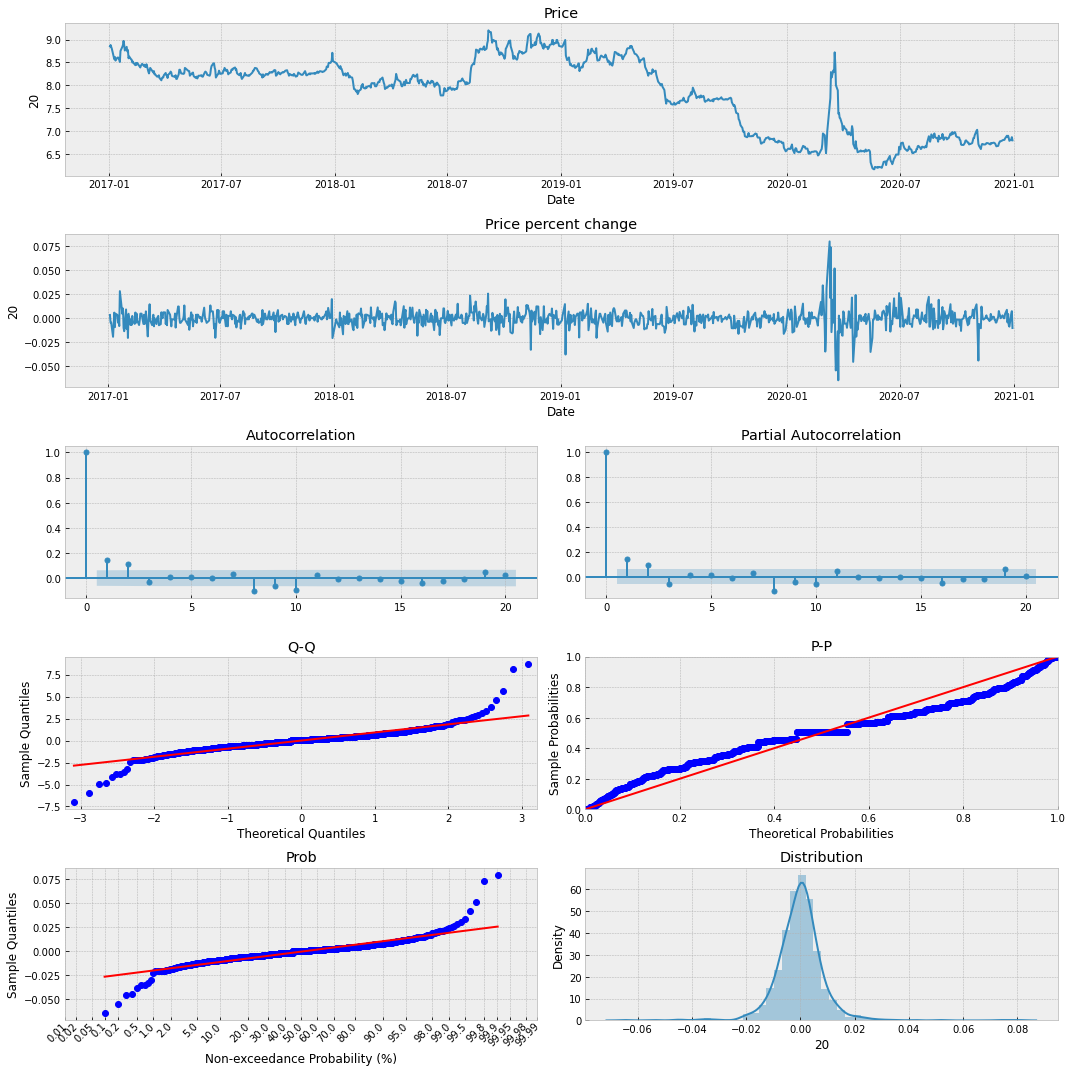

========== 30 ==========
mean: 8.09
std: 0.85
min: 6.37
max: 9.57
The Augmented Dickey-Fuller test, p-value: 0.6419590589333197, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.945079685475978e-20, series is stationary


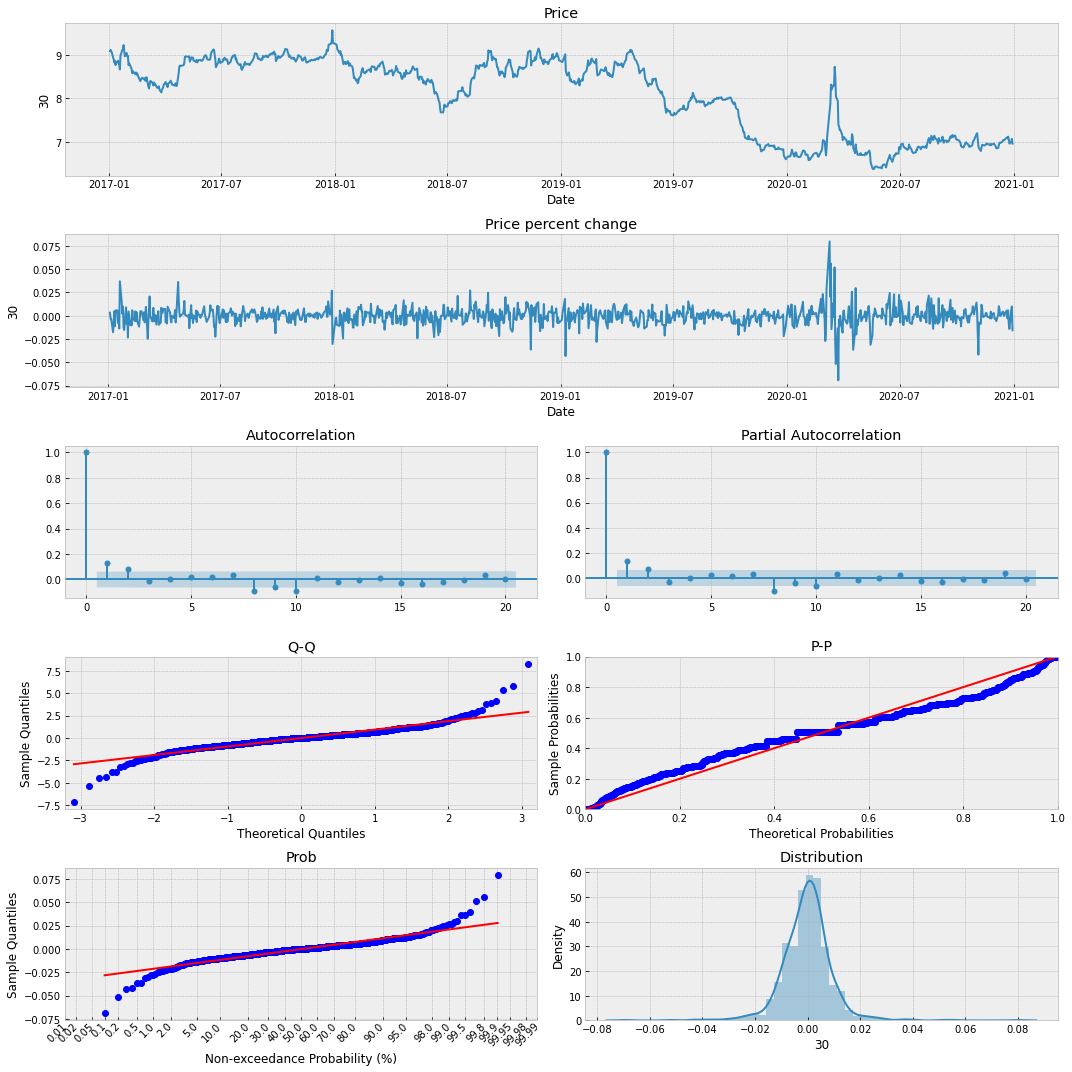

In [18]:
for col in risk_factors.columns:
    risk_factor_describe(risk_factors[col])

# 4. Симуляции риск-факторов

#### Генерация скоррелированных приращений

In [314]:
def get_log(df) -> pd.DataFrame:
    df_log = df.copy()
    for col in df_log.columns:
            df_log[col] = np.log(df_log[col])
    return df_log

In [428]:
def gbm_sim(data, M=10, I=200, S0=0, T=1):
    ''' Generate Monte Carlo paths for geometric Brownian motion
        
    Returns
    =======
    paths : ndarray, shape (M + 1, I)
        simulated paths given the parameters
    '''
    rr = data.diff().values[1:]
    r = np.mean(rr) 
    sigma = np.sqrt((-1 + np.sqrt(1 + 1/(len(rr)) * np.sum((rr - mu)**2)))*2)
    
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = data[S0]
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

Рисуем симуляции

In [316]:
def get_plot_simulation(array, df) -> None:
    for i, col in enumerate(df.columns):
        plt.figure(figsize=(9,6))
        plt.xlim(-0.05, array.shape[1])
        plt.title(col, size=18)
        plt.xlabel('time', size=14)
        plt.ylabel('price', size=14)
        plt.plot(array[i])
        plt.show()

#### *Процентные ставки ~на спорт~*

In [319]:
# risk_factors.columns

In [322]:
interest_rates = risk_factors[['0.25', '0.5', '0.75', 
                              '1', '2', '3', '5', '7', 
                              '10', '15', '20', '30']]
ir_log = get_log(interest_rates)

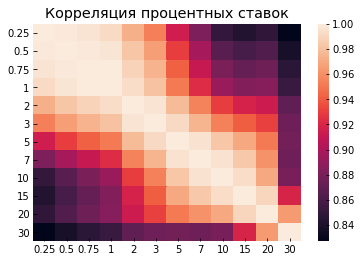

In [323]:
sns.heatmap(ir_log.corr())
plt.title('Корреляция процентных ставок')
plt.show()

In [324]:
for n in range(ir_log.shape[1]-6):
    dim_red = PCA(n_components = n + 1)
    dim_red.fit(ir_log)
    print(" {} component(s)\n explained variance: {}\n".format(n + 1, np.sum(dim_red.explained_variance_ratio_))) 

 1 component(s)
 explained variance: 0.9571979803441707

 2 component(s)
 explained variance: 0.9905357554703131

 3 component(s)
 explained variance: 0.9980374852824786

 4 component(s)
 explained variance: 0.9997343309672518

 5 component(s)
 explained variance: 0.999952943249922

 6 component(s)
 explained variance: 0.9999892446403303



#### Оставим 3 главные компоненты, так как это минимальное кол-во компонент, объясняюшее больше 95% дисперсии.

In [332]:
PCA_ir = PCA(n_components=3)
ir_pca = pd.DataFrame(PCA_ir.fit_transform(ir_log), 
                      columns=['ir_comp_1', 'ir_comp_2', 'ir_comp_3'])

In [333]:
sim_ir_vas = []
for col in ir_pca.columns:
    sim = gbm_sim(ir_pca[col], 0, 1, 10, 200)
    sim_ir_vas.append(sim)
sim_ir_vas = np.array(sim_ir_vas)

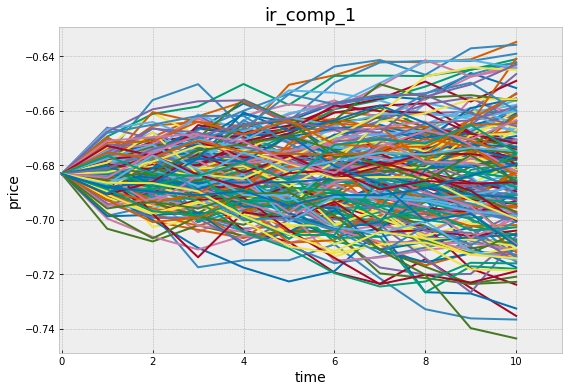

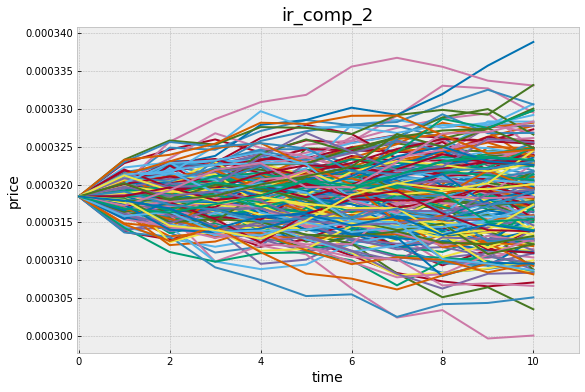

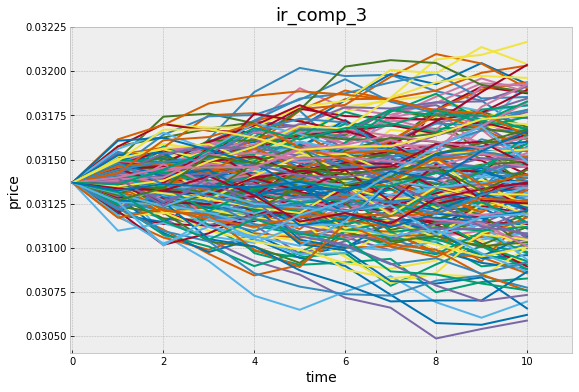

In [334]:
get_plot_simulation(sim_ir_vas, ir_pca)

#### *Драгоценные металы*

In [335]:
metal = risk_factors[['Gold', 'Argent', 'Platine', 'Palladium']]
metal_log = get_log(metal)

In [336]:
sim_met = []
for col in metal_log.columns:
    sim = gbm_sim(metal_log[col], 0, 1, 10, 200)
    sim_met.append(sim)
sim_met = np.array(sim_met)

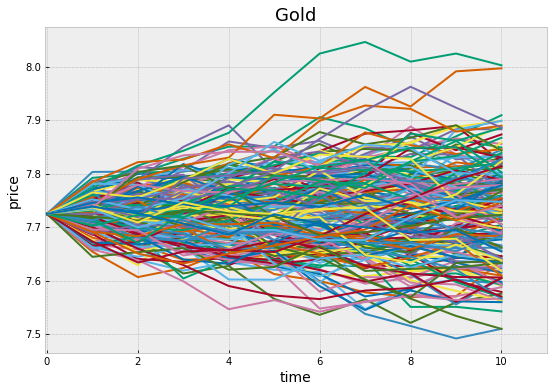

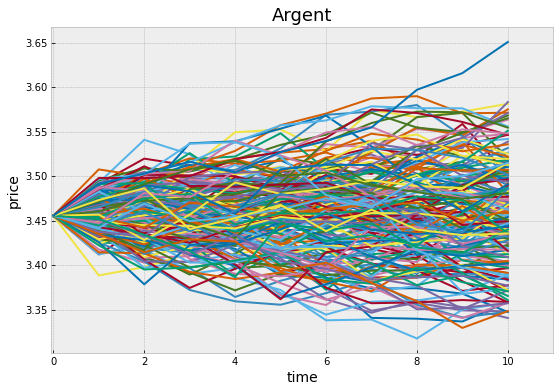

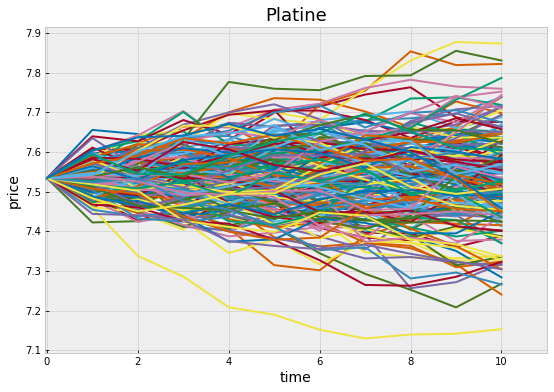

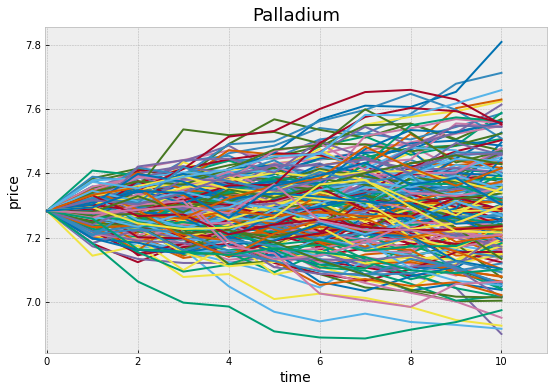

In [337]:
# Рандомный Волк
get_plot_simulation(sim_met, metal_log)

#### *Индексы*

In [341]:
idx_df = risk_factors[['IMOEX.ME', 'RTS']]
idx_df_log = get_log(idx_df)

In [344]:
sim_idx = []
for col in idx_df_log.columns:
    sim = gbm_sim(idx_df_log[col], 10, 200)
    sim_idx.append(sim)
sim_idx = np.array(sim_idx)

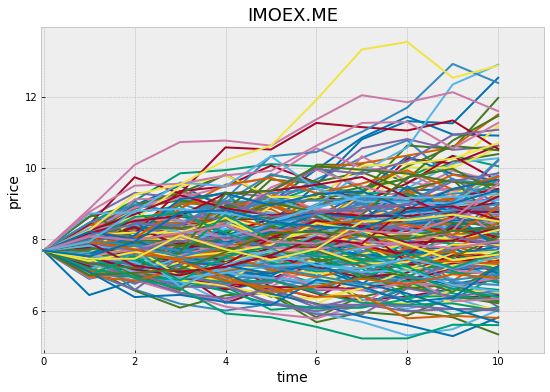

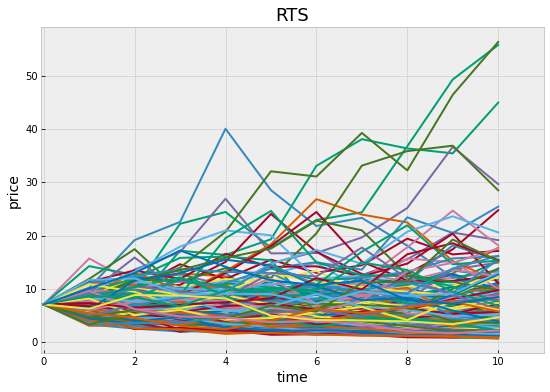

In [345]:
get_plot_simulation(sim_idx, idx_df_log)

#### *Черное Золото и валюта*

In [346]:
cur_oil = risk_factors[['BZ=F', 'JPY', 'EUR', 'GBP']]
cur_oil_log = get_log(cur_oil)

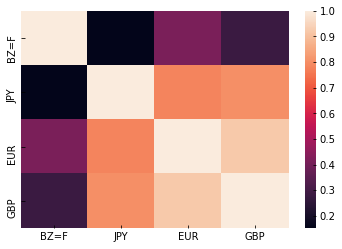

In [347]:
sns.heatmap(cur_oil_log.corr())
plt.show()

In [348]:
pca_dim = PCA(n_components = 2)
cur_oil_pca = pd.DataFrame(pca_dim.fit_transform(cur_oil_log), columns=['cur_oil_comp_1', 'cur_oil_comp_2'])
print("Explained variance ratio: {}".format(np.sum(pca_dim.explained_variance_ratio_)))

Explained variance ratio: 0.9872217428075866


In [349]:
sim_cur_oil = []
for col in cur_oil_pca.columns:
    sim = gbm_sim(cur_oil_pca[col], 10, 200)
    sim_cur_oil.append(sim)
sim_cur_oil = np.array(sim_cur_oil)

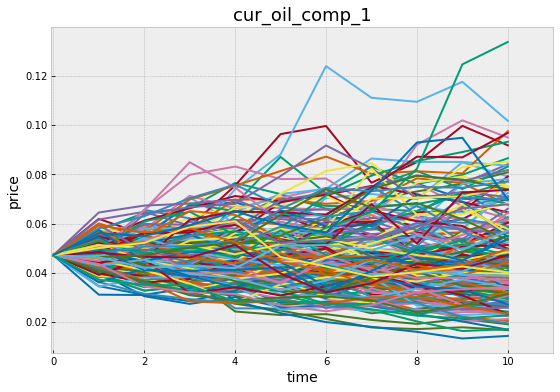

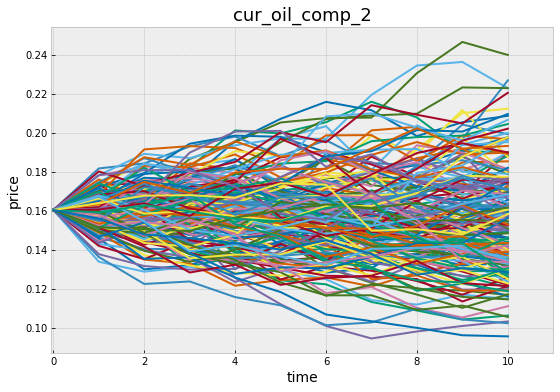

In [350]:
get_plot_simulation(sim_cur_oil, cur_oil_pca)

#### Предсказание 

In [357]:
pca = PCA(n_components = 2)
reduced_indexes = pca.fit_transform(idx_df_log)
print(np.sum(pca.explained_variance_ratio_))
reduced_curr_oil = pca.fit_transform(cur_oil_log)
print(np.sum(pca.explained_variance_ratio_))
reduced_rates = pca.fit_transform(ir_log)
print(np.sum(pca.explained_variance_ratio_))
reduced_metal = pca.fit_transform(metal_log)
print(np.sum(pca.explained_variance_ratio_))

1.0
0.9872217428075869
0.9905357554703121
0.9889101315685779


In [360]:
reduced_data = pd.DataFrame(np.hstack([reduced_indexes, reduced_curr_oil, reduced_rates, reduced_metal]), 
                            columns=['reduced_indexes_1', 'reduced_indexes_2', 
                                     'reduced_curr_oil_1', 'reduced_curr_oil_2', 
                                     'reduced_rates_1', 'reduced_rates_2', 
                                     'reduced_metal_1', 'reduced_metal_2',], 
                            index=idx_df_log.index)

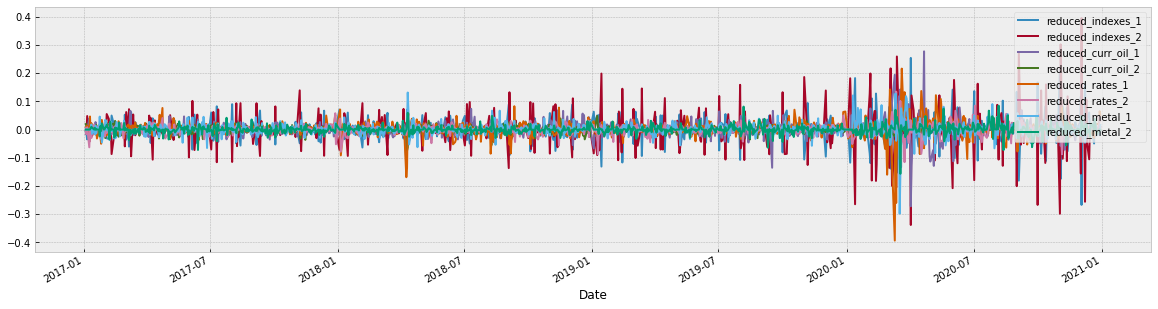

In [361]:
reduced_data.diff().dropna().plot(figsize=(20, 5))
plt.show()

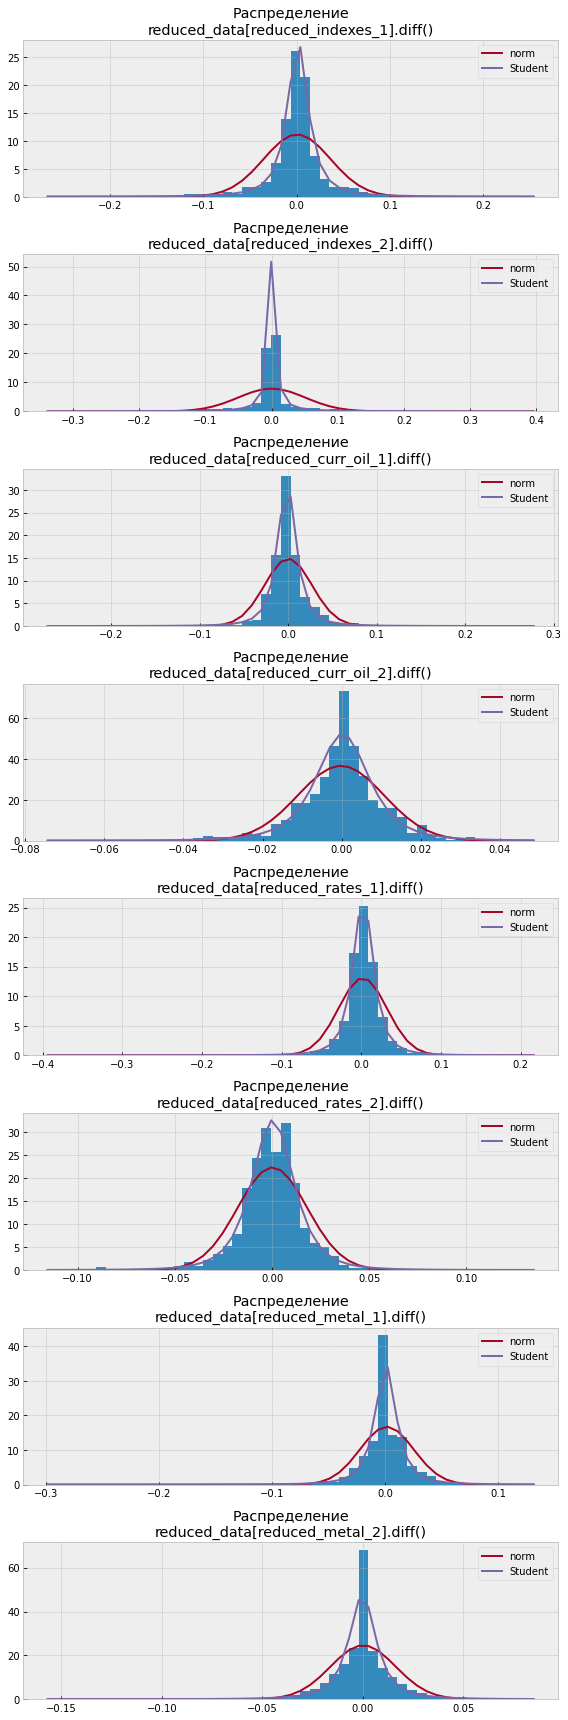

In [362]:
fig, ax = plt.subplots(len(reduced_data.columns), 1, figsize=(8, 24))
for i, col in enumerate(reduced_data.columns):
    r = reduced_data[col].diff().dropna()
    params_norm = ss.norm.fit(r)
    params_t = ss.t.fit(r)
    vals, grid, _ = ax[i].hist(r, 50, density=True)
    ax[i].plot(grid, ss.norm(*params_norm).pdf(grid), label='norm')
    ax[i].plot(grid, ss.t(*params_t).pdf(grid),label='Student');
    ax[i].legend()
    ax[i].set_title(f'Распределение\nreduced_data[{col}].diff()')
    plt.tight_layout()

In [368]:
paths_dict = dict()

for col in reduced_data.columns:
    paths_dict[col] = gbm_sim(reduced_data[col], 10, I=1000)

In [393]:
curr = np.log(currencies)

USD_forecast = []
CNY_forecast = []
LR = LinearRegression()
LR.fit(reduced_data, np.log(curr['USD'].to_numpy()))
for i in range(1000):
    pred = LR.predict(np.vstack([paths_dict['reduced_indexes_1'].T[i],
                                           paths_dict['reduced_indexes_2'].T[i], 
                                           paths_dict['reduced_curr_oil_1'].T[i], 
                                           paths_dict['reduced_curr_oil_2'].T[i], 
                                           paths_dict['reduced_rates_1'].T[i], 
                                           paths_dict['reduced_rates_2'].T[i], 
                                           paths_dict['reduced_metal_1'].T[i], 
                                           paths_dict['reduced_metal_2'].T[i],]).T)
    USD_forecast.append(pred)

LR = LinearRegression()
LR.fit(reduced_data, np.log(curr['CNY'].to_numpy()))
for i in range(1000):
    pred = LR.predict(np.vstack([paths_dict['reduced_indexes_1'].T[i],
                                           paths_dict['reduced_indexes_2'].T[i], 
                                           paths_dict['reduced_curr_oil_1'].T[i], 
                                           paths_dict['reduced_curr_oil_2'].T[i], 
                                           paths_dict['reduced_rates_1'].T[i], 
                                           paths_dict['reduced_rates_2'].T[i], 
                                           paths_dict['reduced_metal_1'].T[i], 
                                           paths_dict['reduced_metal_2'].T[i],]).T)
    CNY_forecast.append(pred)

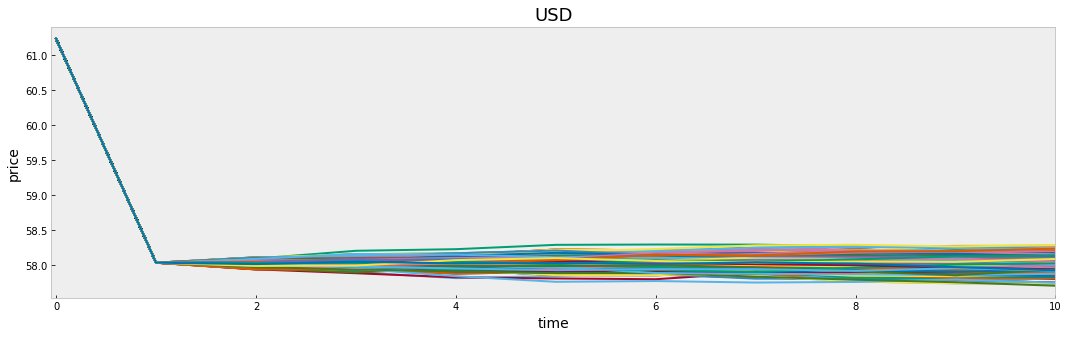

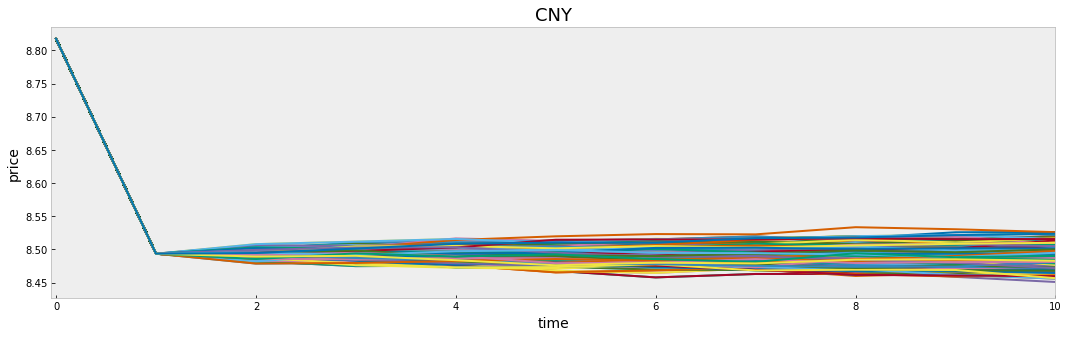

In [400]:
#Plotting
for i, j in zip(curr.columns, [USD_forecast, CNY_forecast]):
    plt.figure(figsize=(18,5))
    plt.xlim(-0.05, 10)
    plt.title(i, size=18)
    plt.xlabel('time', size=14)
    plt.ylabel('price', size=14)
    plt.grid()
    for _ in range(500):

        tmp = np.zeros(12)

        tmp[0] = curr[i][0]

        tmp[1:] = np.exp(j[np.random.randint(1000)]).reshape(11)
        plt.plot(np.exp(tmp))
    plt.show();

In [401]:
stocks = np.log(shares)

stocks_forecast = {}
for name in stocks.columns:
    LR = LinearRegression(n_jobs=8)
    LR.fit(reduced_data, stocks[name].to_numpy())
    forecast = []
    for i in range(1000):
        pred = LR.predict(np.vstack([paths_dict['reduced_indexes_1'].T[i],
                                     paths_dict['reduced_indexes_2'].T[i],
                                     paths_dict['reduced_curr_oil_1'].T[i],
                                     paths_dict['reduced_curr_oil_2'].T[i],
                                     paths_dict['reduced_rates_1'].T[i],
                                     paths_dict['reduced_rates_2'].T[i],
                                     paths_dict['reduced_metal_1'].T[i], 
                                     paths_dict['reduced_metal_2'].T[i],]).T)
        forecast.append(pred)
    stocks_forecast[name] = forecast

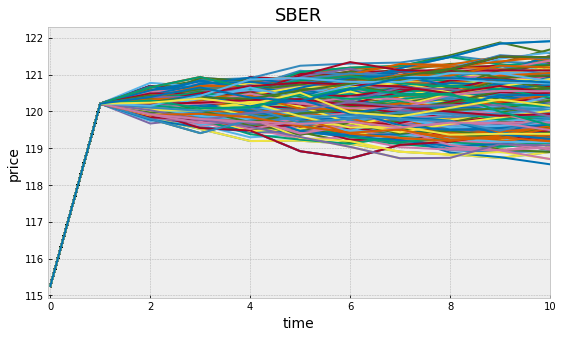

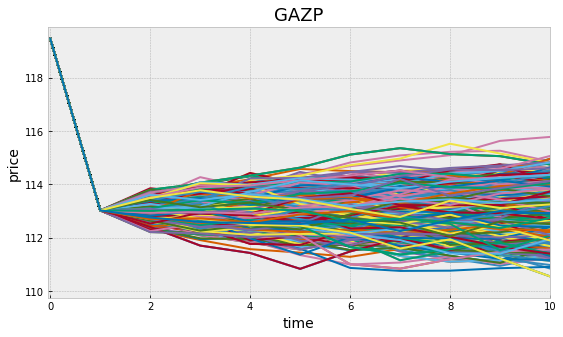

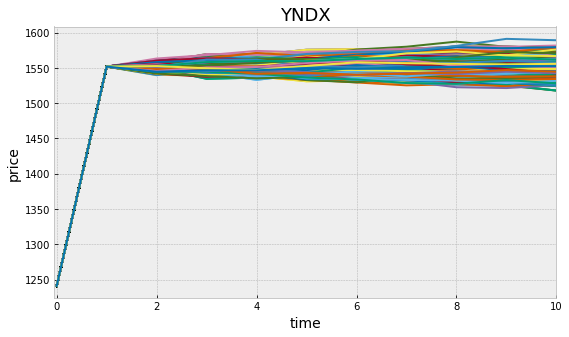

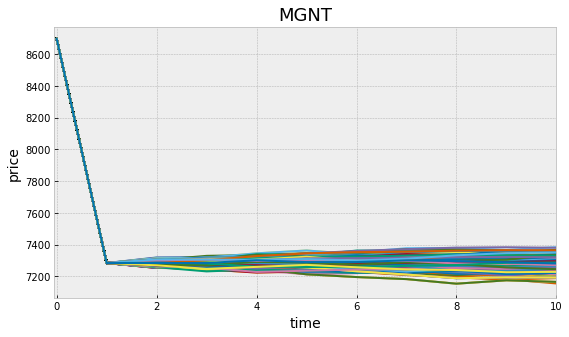

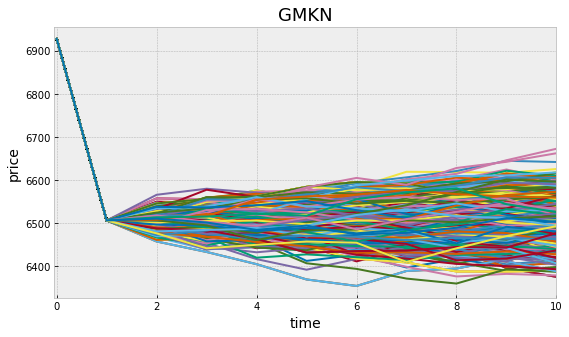

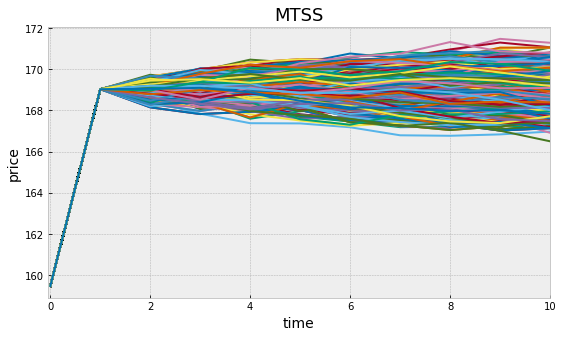

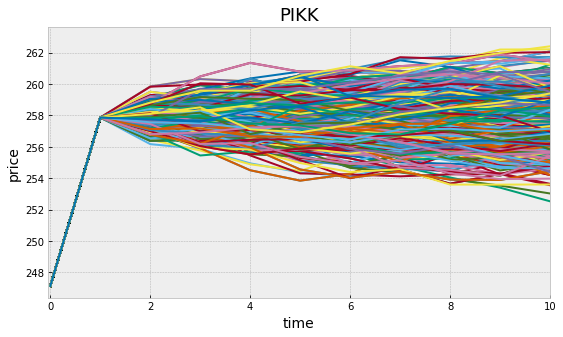

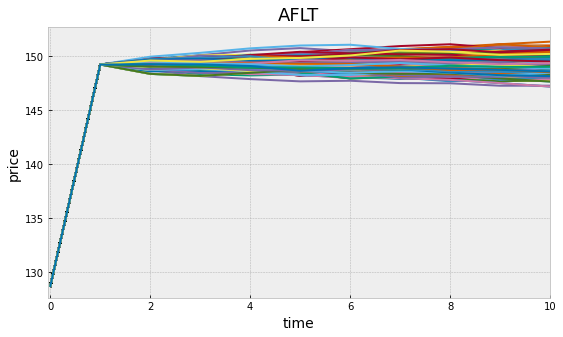

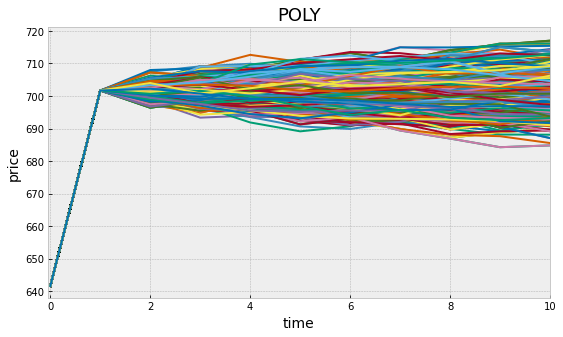

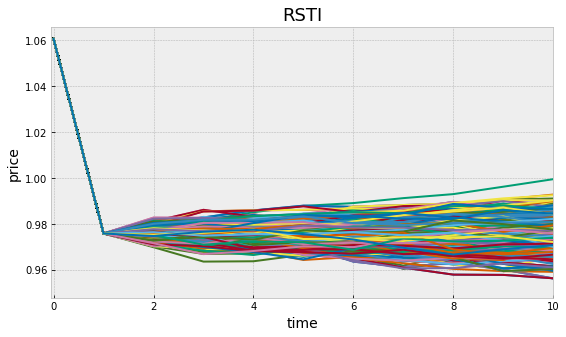

In [409]:
for i in stocks.columns:
    plt.figure(figsize=(9,5))
    plt.xlim(-0.05, 10)
    plt.title(i, size=18)
    plt.xlabel('time', size=14)
    plt.ylabel('price', size=14)
    
    for _ in range(1000):
        tmp = np.zeros(12)
        tmp[0] = stocks[i][0]
        tmp[1:] = stocks_forecast[i][np.random.randint(1000)].reshape(11)
        plt.plot(np.exp(tmp))
    plt.show()

# 5. Составляем портфель и перебалансируем на каждый день

In [410]:
obligation_coupons_files = ['bonds\SU26205RMFS3.csv', 'bonds\SU26209RMFS5.csv', 'bonds\SU26212RMFS9.csv', 
                            'bonds\SU26215RMFS2.csv', 'bonds\SU26217RMFS8.csv']
def payment_per_day_bonds(obligation_coupons_files=obligation_coupons_files):

    obligation_coupons = []
    for i in range(len(obligation_coupons_files)):
        obligation_coupon = pd.read_csv(obligation_coupons_files[i])
        obligation_coupon.date = pd.to_datetime(obligation_coupon.date)
        days = (obligation_coupon[['date']].iloc[-2] \
                - obligation_coupon[['date']].iloc[-3]).values[0].astype('timedelta64[D]').astype(int)
        payment_per_day = obligation_coupon['payment'].iloc[-2] / days
        obligation_coupons.append(payment_per_day)

    return np.round(obligation_coupons, 5)

In [411]:
def calculate_portfolio_distribution(bonds=bonds, 
                                     shares=shares, 
                                     currencies=currencies):
    
    dirty_bonds = bonds + payment_per_day_bonds()
    df_for_portfolio = dirty_bonds.join((shares, currencies), how='left')
    
    position_0 = np.array([10e6] * 5 + [1e6] * 10 + [10e6] * 2)
    day_prices = df_for_portfolio.iloc[0] 
    true_qty = position_0 / day_prices
    qty = np.round(position_0 / day_prices, 0).astype(int)
    portfolio_qty_shares_true = (true_qty * day_prices) / (true_qty * day_prices).sum()
    
    all_qty = qty
    all_price = day_prices
    
    for t in range(1, df_for_portfolio.shape[0]):
        day_prices = df_for_portfolio.iloc[t-1]
        wts = (qty * day_prices) / np.sum(qty * day_prices)
        delta_wts = portfolio_qty_shares_true / wts
        qty = np.round(qty * delta_wts, 0).astype(int)
        all_qty = np.vstack((all_qty, qty))
        all_price = np.vstack((all_price, day_prices))
    
    number_of_assets = pd.DataFrame(all_qty, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    prices_of_assets = pd.DataFrame(all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    total_sum = pd.DataFrame(all_qty*all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    
    return number_of_assets, prices_of_assets, total_sum

In [412]:
number_of_assets, prices_of_assets, sum_portfolio = calculate_portfolio_distribution()

In [460]:
num_bonds = number_of_assets.iloc[:, 0:5]
num_currencies = number_of_assets.iloc[:, 15:17] 

In [414]:
ret = prices_of_assets.pct_change()
ret.dropna(inplace=True)

bonds_ret = ret.iloc[:, 0:5]
shares_ret = ret.iloc[:, 5:15]
currencies_ret = ret.iloc[:, 15:17]

In [415]:
bonds_ = prices_of_assets.iloc[:, 0:5]
shares_ = prices_of_assets.iloc[:, 5:15]
currencies_ = prices_of_assets.iloc[:, 15:17]  

# ------------------------------------------------------

In [481]:
from sklearn.ensemble import GradientBoostingRegressor

def get_VaR_ES(data, num_assets, risk_factors, num_sims, L_history = 150, horizon = 1):

    rr = get_log(data).dropna()
    rr= ((rr*num_assets).pct_change()).dropna()
    
    risk_factors = risk_factors.pct_change().dropna()
    
    w = [1/rr.shape[1] for x in range(rr.shape[1])]
    
    paths_dict = dict()

#     for col in risk_factors.columns:
#         paths_dict[col] = gbm_sim(risk_factors[col], M=horizon, I=num_sims)[-1]
    
#     sims = pd.DataFrame(np.array(list(paths_dict.values())).squeeze().T,
#                         index=range(num_sims), columns = risk_factors.columns)
    VaR, VaR_for_ES, ES = np.full(rr.shape, np.nan), np.full(rr.shape, np.nan), np.full(rr.shape, np.nan)
    for j, col in enumerate(rr):
        r = rr[col]
        for i in tqdm(range(L_history, len(r))):  
            
            

            history = r[i - L_history: i]

            for col in risk_factors.columns:
                paths_dict[col] = gbm_sim(risk_factors[col], S0=i - L_history, M=horizon, I=num_sims)[-1]
            sims = pd.DataFrame(np.array(list(paths_dict.values())).squeeze().T,
                        index=range(num_sims), columns = risk_factors.columns)
            
#             LR = LinearRegression() 
#             LR.fit(risk_factors.iloc[i - L_history: i], history)

#             pred = LR.predict(sims)
            
            GB = GradientBoostingRegressor()
            GB.fit(risk_factors.iloc[i - L_history: i], history)
            pred = GB.predict(sims)
            
            
            VaR[i, j] = np.quantile(pred, 0.01) 
            if VaR[i, j] >= 0: 
                VaR[i, j] = VaR[i-3, j] 
                
            VaR_for_ES[i, j] = np.quantile(pred, 0.025)
            if VaR_for_ES[i, j] >= 0:
                VaR_for_ES[i, j] = VaR_for_ES[i-3, j]
    

            ES[i, j] = history[history <= VaR_for_ES[i, j]].mean()
            if np.isnan(ES[i, j]).sum() == 1:
                ES[i, j] = VaR_for_ES[i, j] 

    VaR = pd.Series(data=VaR.mean(axis=1), index=r.index) 
    ES = pd.Series(data=ES.mean(axis=1), index=r.index)    
    
    return VaR, ES

In [461]:
rf_bonds = reduced_data[['reduced_indexes_1', 'reduced_indexes_2', 'reduced_rates_1', 
              'reduced_rates_2', 'reduced_metal_1', 'reduced_metal_2']]
rf_shares = rf_bonds.copy()
rf_currencies = reduced_data[['reduced_curr_oil_1', 'reduced_curr_oil_2',]]

In [467]:
rf_currencies

reduced_curr_oil_1  reduced_curr_oil_2
Date                                              
2017-01-03            0.043145            0.132277
2017-01-04            0.028017            0.151786
2017-01-05            0.022048            0.163797
2017-01-06            0.019062            0.169318
2017-01-09            0.058464            0.176401
...                        ...                 ...
2020-12-24            0.105521           -0.015492
2020-12-25            0.105521           -0.015492
2020-12-28            0.112127           -0.016306
2020-12-29            0.107654           -0.015755
2020-12-30            0.102814           -0.015158

[1008 rows x 2 columns]

In [456]:
VaR, ES = get_VaR_ES(bonds_, num_bonds, rf_shares, 200, L_history = 100, horizon=1)

In [458]:
VaR_10, ES_10 = get_VaR_ES(bonds_, num_bonds, rf_shares, 200, L_history = 100, horizon=10)

In [482]:
VaR_c, ES_c = get_VaR_ES(currencies_, num_currencies, rf_currencies, 200, L_history = 100, horizon=1)

Пока не удалять, для тестов

In [214]:
# data = bonds_.copy()
# risk_factors = rf_bonds
# num_simns = 1000
# L_history = 100 
# horizon = 10

# rr = get_log(data).dropna()
# w = [1/rr.shape[1] for x in range(rr.shape[1])]

# paths_dict = dict()

# for col in risk_factors.columns:
#     paths_dict[col] = gbm_sim(risk_factors[col], horizon, num_simns)[-1]

# sims = pd.DataFrame(np.array(list(paths_dict.values())).squeeze().T,
#                     index=range(num_simns), columns = risk_factors.columns)

# VaR, VaR_for_ES, ES = np.full(rr.shape, np.nan), np.full(rr.shape, np.nan), np.full(rr.shape, np.nan)
# for j, col in enumerate(rr):
#     r = rr[col]
#     for i in tqdm(range(L_history, len(r))):  

#         history = r[i - L_history: i]
#         LR = LinearRegression() 
#         LR.fit(risk_factors.iloc[i - L_history: i], history)

#         pred = LR.predict(sims)

#         VaR[i, j] = np.quantile(pred, 0.01) 
#         VaR_for_ES[i, j] = np.quantile(pred, 0.025)

#         ES[i, j] = history[history <= VaR_for_ES[i, j]].mean()
#         if np.isnan(ES[i, j]).sum() == 1:
#             ES[i, j] = VaR_for_ES[i, j] 

# VaR = pd.Series(data=VaR.mean(axis=1), index=r.index) 
# ES = pd.Series(data=ES.mean(axis=1), index=r.index)  

In [240]:
VaR

Date
2017-01-04         NaN
2017-01-05         NaN
2017-01-06         NaN
2017-01-09         NaN
2017-01-10         NaN
                ...   
2020-12-24   -0.752587
2020-12-25   -0.895330
2020-12-28   -1.115788
2020-12-29   -1.301827
2020-12-30   -1.295479
Length: 1007, dtype: float64

In [435]:
bonds_

SU26205RMFS3  SU26209RMFS5  SU26212RMFS9  SU26215RMFS2  \
Date                                                                 
2017-01-03      98.85814      98.60654      91.59323      94.21296   
2017-01-04      98.85814      98.60654      91.59323      94.21296   
2017-01-05      98.90794      98.65714      92.24293      94.79156   
2017-01-06      99.15804      98.60804      92.29303      94.88166   
2017-01-09      99.20814      98.70794      92.63303      94.59246   
...                  ...           ...           ...           ...   
2020-12-24     101.23724     104.88824     108.12313     105.39176   
2020-12-25     101.22524     104.88824     108.14313     105.23176   
2020-12-28     101.19724     104.93824     108.18813     105.39176   
2020-12-29     101.23824     105.04624     108.19413     105.67176   
2020-12-30     101.26824     105.08524     108.25113     105.57876   

            SU26217RMFS8  
Date                      
2017-01-03      98.30529  
2017-01-04      98.30529  
2017-01-05      98.30529  
2017-01-06      98.30529  
2017-01-09      98.40549  
...                  ...  
2020-12-24     102.18649  
2020-12-25     102.22449  
2020-12-28     102.20549  
2020-12-29     102.23549  
2020-12-30     102.28349  

[1008 rows x 5 columns]

In [446]:
VaR

Date
2017-01-04         NaN
2017-01-05         NaN
2017-01-06         NaN
2017-01-09         NaN
2017-01-10         NaN
                ...   
2020-12-24   -0.001274
2020-12-25   -0.001392
2020-12-28   -0.001566
2020-12-29   -0.001324
2020-12-30   -0.001315
Length: 1007, dtype: float64

In [447]:
rr.mean(axis=1)

Date
2017-01-04   -0.000031
2017-01-05   -0.002544
2017-01-06   -0.002884
2017-01-09   -0.003245
2017-01-10    0.000302
                ...   
2020-12-24    0.005498
2020-12-25   -0.003627
2020-12-28   -0.002525
2020-12-29    0.000720
2020-12-30    0.000805
Length: 1007, dtype: float64

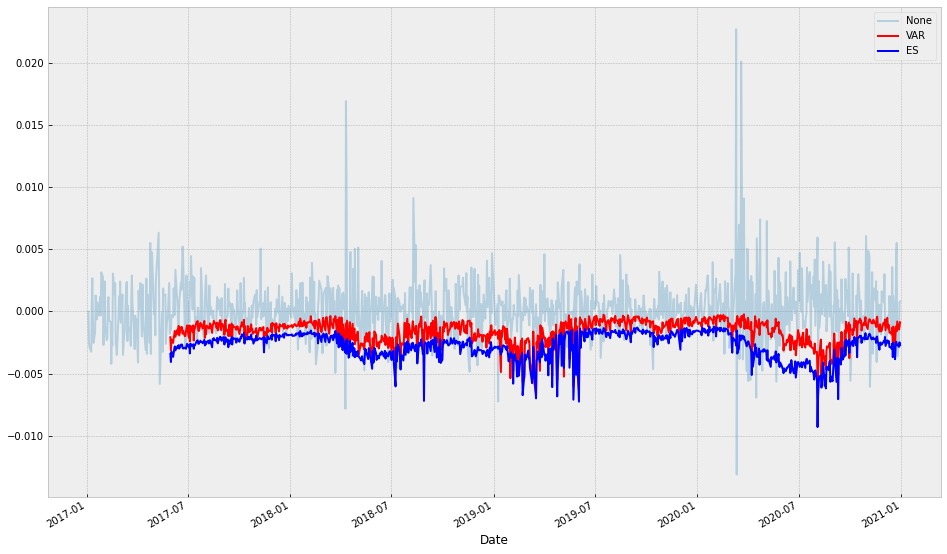

In [457]:
rr = get_log(bonds_).dropna()
rr= ((rr* num_bonds).pct_change()).dropna()

# rr = get_log(shares_).dropna()
# rr= rr.diff().dropna()

rr.mean(axis=1).plot(figsize=(16,10), alpha=0.3)
VaR.plot(color='red', label='VAR')
ES.plot(color='blue', label='ES')
plt.legend()
plt.show()

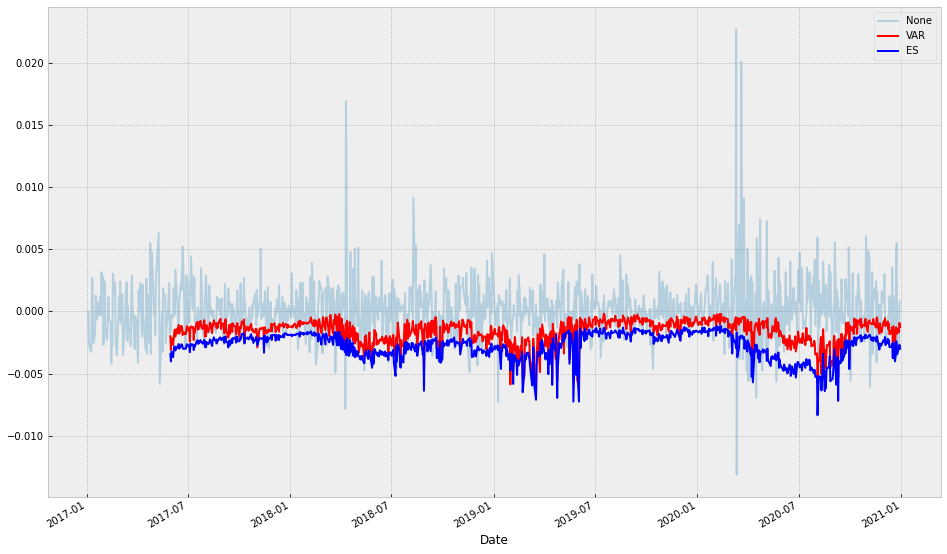

In [459]:
rr = get_log(bonds_).dropna()
rr= ((rr* num_bonds).pct_change()).dropna()

# rr = get_log(shares_).dropna()
# rr= rr.diff().dropna()

rr.mean(axis=1).plot(figsize=(16,10), alpha=0.3)
VaR_10.plot(color='red', label='VAR')
ES_10.plot(color='blue', label='ES')
plt.legend()
plt.show()

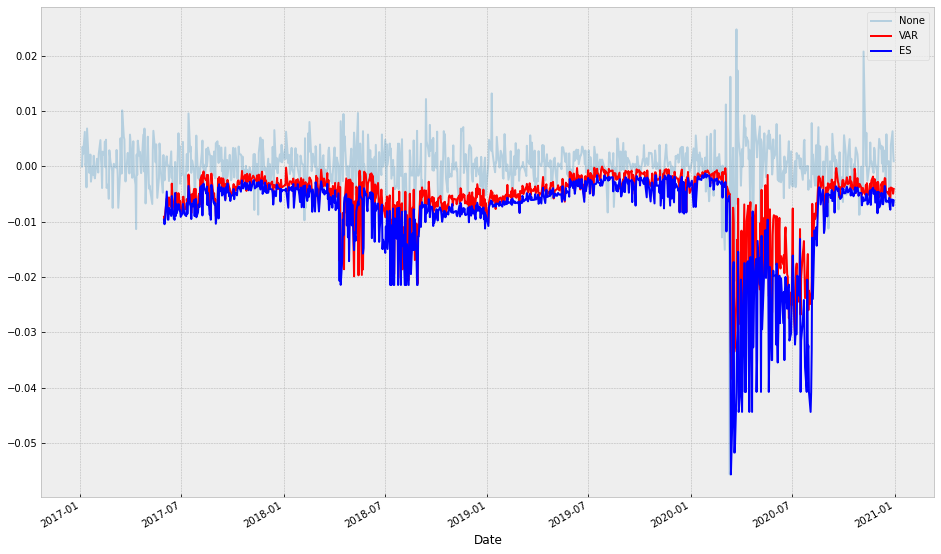

In [483]:
rr = get_log(currencies_).dropna()
rr= ((rr* num_currencies).pct_change()).dropna()

# rr = get_log(shares_).dropna()
# rr= rr.diff().dropna()

rr.mean(axis=1).plot(figsize=(16,10), alpha=0.3)
VaR_c.plot(color='red', label='VAR')
ES_c.plot(color='blue', label='ES')
plt.legend()
plt.show()

In [500]:
pt

reduced_indexes  reduced_rates  reduced_raw  reduced_curr
Date                                                                 
2017-01-04         0.046893      -0.004032    -0.322737      0.093218
2017-01-05         0.090604      -0.017100    -0.206979      0.091383
2017-01-06         0.339541      -0.021808    -0.127464      0.166345
2017-01-09        -0.206756      -0.016483     1.502597     -0.005889
2017-01-10        -0.047108      -0.074452     0.361361     -0.081201
...                     ...            ...          ...           ...
2020-12-24         0.013260       0.014155     0.000000     -0.066823
2020-12-25         0.000066       0.008274     0.000000     -0.078829
2020-12-28         0.046803       0.004806     0.046337     -0.013434
2020-12-29         0.027505       0.009220    -0.029958      0.000614
2020-12-30        -0.011700       0.031265    -0.033568      0.011631

[1007 rows x 4 columns]

In [499]:
ES

Date
2017-01-04   -0.000812
2017-01-05   -0.000812
2017-01-06   -0.000812
2017-01-09   -0.000812
2017-01-10   -0.000812
                ...   
2020-12-24   -0.000812
2020-12-25   -0.000812
2020-12-28   -0.000812
2020-12-29   -0.000812
2020-12-30   -0.000812
Length: 1007, dtype: float64

In [482]:
VaR

Date
2017-01-04   NaN
2017-01-05   NaN
2017-01-06   NaN
2017-01-09   NaN
2017-01-10   NaN
              ..
2020-12-24   NaN
2020-12-25   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
Length: 1007, dtype: float64

In [ ]:
def calculate_var(date, horizon=1, level=0.99):
    np.random.seed(1)
    current_quantity = number_of_assets.iloc[date]
    #Симулируем движение риск-факторов
    paths_dict = dict()
    
    for name in reduced_data.columns:
        paths_dict[name] = gbm_sim(reduced_data.iloc[date:][name],1,500)
        
    fx_gains = 0
    
    for i in range(0, 2):
        LR = LinearRegression()
        LR.fit(reduced_data.iloc[date:,3:], currencies_.iloc[date:, i:i+1])
        pred = LR.predict(paths_dict['reduced_curr'].T)

        mdl = arch_model(LR_resids, mean='Constant', lags=1, 
                    vol='GARCH', p=1, o=1, 
                    q=1, dist='skewt') 
        res = mdl.fit(disp='off', show_warning=False)
        forecasts = res.forecast(horizon=1)

        garch_resids = res.resid

        fx_gains += (pred - garch_resids) * current_quantity[i]
    
    fx_pred = np.mean(fx_gains)
    fx_var = np.quantile(fx_gains, 1-level)
    
    return fx_var

In [ ]:
def calc_VaR_and_ES(r, VaR_fun, L_history=170, level_VaR=0.01, level_ES=0.025, horizon=1):
    VaR, VaR_for_ES, ES = np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan)
    
    for i in tqdm(range(L_history, len(r))):
        history = r[i - L_history: i]
        h = np.dot(history, np.array([1/r.shape[1] for x in range(r.shape[1])]))
        VaR[i] = VaR_fun(h, level_VaR, horizon) 
        if VaR[i] < -0.25:
            VaR[i] = VaR[i-1]
        VaR_for_ES[i] = VaR_fun(h, level_ES, horizon) 
        
        ES[i] = h[h < VaR_for_ES[i]].mean()
    
    VaR = pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__) 
    ES = pd.Series(data=ES, index=r.index, name=VaR_fun.__name__)  
    
    return VaR, ES

def calculate_VaR_HS(ret, alpha=0.01, horizon=1):

    return np.quantile(ret, alpha)

def calculate_VaR_garch(returns, alpha, h=1):
    scaling_const = 10 / returns.std()
    mdl = arch_model(returns * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=1, o=1, 
                    q=1, dist='skewt') 
    
    res = mdl.fit(disp='off', show_warning=False)

    forecasts = res.forecast(horizon=h)
    
    
    cond_mean = float(forecasts.mean.iloc[-1].mean())
    cond_var = float(forecasts.variance.iloc[-1].mean())

    q = mdl.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

In [233]:
from arch import arch_model 
from copulae import StudentCopula, ClaytonCopula, GumbelCopula

def get_garch_residuals(ret, dist):

    scaling_const = 10.0 / ret.std()
    
    # объявляем GARCH модель
        
    am = arch_model(ret * scaling_const,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])
        
    return cdf, am, res, scaling_const


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const


def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res, scaling_const)
            cdfs[col] = np.concatenate((np.array([0]), cdf))

    # фитим копулу
    cop.fit(cdfs)
    

    # делаем сэмплирование marginals из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)
    

    return_simulations = copula_simulations.copy()

    # трансформируем marginals в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res, scaling_const = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

In [234]:
return_simulations = make_copula_simulation(bonds_ret, ClaytonCopula,
                                            n_samples=10**4, univariate_dist='garch')

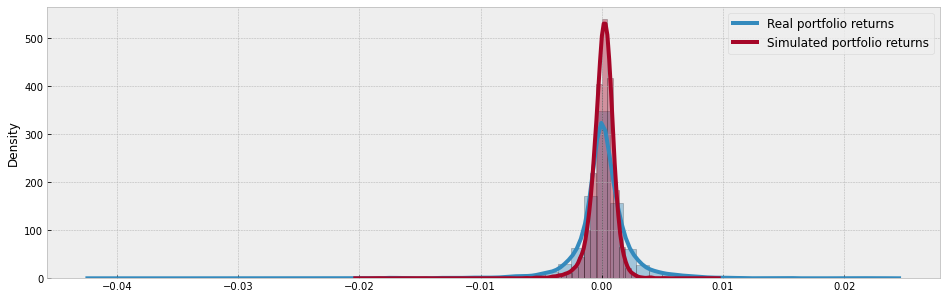

In [248]:
portfolio_simulated_returns = np.dot(return_simulations.values, np.array([0.2] * 5))

fig = plt.figure(figsize=(16, 5))

sns.distplot(bonds_ret, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [250]:
def make_gmm_simulations(returns, n_samples=10**3):

    n_components = 6

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=3, random_state=42) # full spherical
    gmm.fit(returns.values)

    return_simulations = gmm.sample(n_samples=n_samples)[0]

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)

def make_copula_simulation_wrap(returns):
    
    return_simulations = make_copula_simulation(returns, ClaytonCopula,
                                            n_samples=10**3, univariate_dist='garch')
    
    return return_simulations

VaR_copulanorm_garch = calc_VaR(bonds_ret, make_copula_simulation_wrap, np.array([0.2] * 5))

<Figure size 1152x720 with 0 Axes>

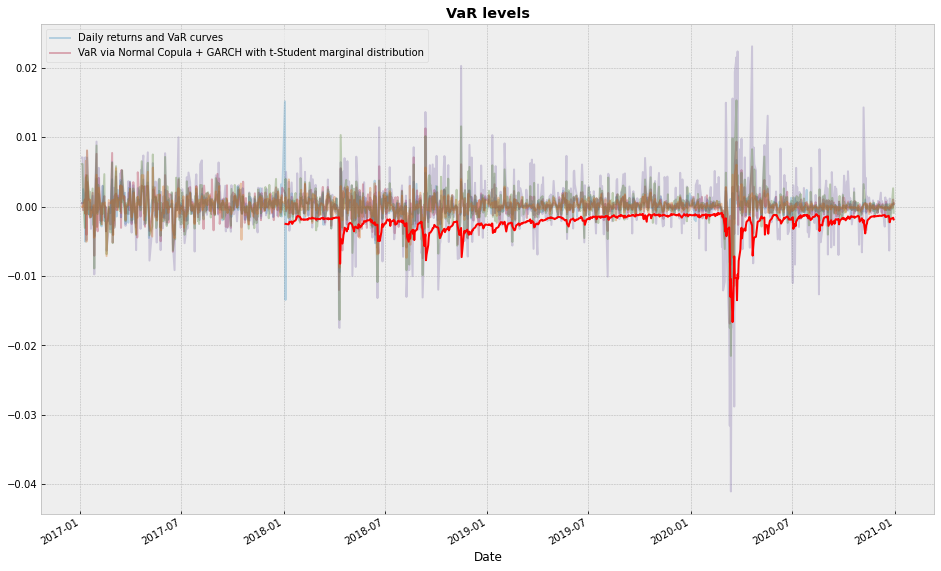

In [277]:
fig = plt.figure(figsize=(16, 10))

bonds_ret.plot(figsize=(16, 10), alpha = 0.3)
VaR_copulanorm_garch.plot(c='red')

plt.title("VaR levels", weight="bold")

plt.legend(['Daily returns and VaR curves',
#             'VaR via Multivariate normal',
           'VaR via Normal Copula + GARCH with t-Student marginal distribution'])

plt.show()

# VaR и ES без риск факторов на гарчах

In [466]:
def calc_VaR_and_ES(r, VaR_fun, L_history=170, level_VaR=0.01, level_ES=0.025, horizon=1):
    VaR, VaR_for_ES, ES = np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan)
    
    for i in tqdm(range(L_history, len(r))):
        history = r[i - L_history: i]
        h = np.dot(history, np.array([1/r.shape[1] for x in range(r.shape[1])]))
        VaR[i] = VaR_fun(h, level_VaR, horizon) 
        if VaR[i] < -0.25:
            VaR[i] = VaR[i-3]
        VaR_for_ES[i] = VaR_fun(h, level_ES, horizon) 
        if VaR_for_ES[i] < -0.25:
            VaR[i] = VaR[i-3]
        
        ES[i] = h[h < VaR_for_ES[i]].mean()
    
    VaR = pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__) 
    ES = pd.Series(data=ES, index=r.index, name=VaR_fun.__name__)  
    
    return VaR, ES

def calculate_VaR_HS(ret, alpha=0.01, horizon=1):

    return np.quantile(ret, alpha)

def calculate_VaR_garch(returns, alpha, h=1):
    scaling_const = 10 / returns.std()
    mdl = arch_model(returns * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=1, o=1, 
                    q=1, dist='skewt') 
    
    res = mdl.fit(disp='off', show_warning=False)

    forecasts = res.forecast(horizon=h)
    
    
    cond_mean = float(forecasts.mean.iloc[-1].mean())
    cond_var = float(forecasts.variance.iloc[-1].mean())

    q = mdl.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

In [467]:
def plot_hist_GARCH(data, data_name, VaR_level=0.01, ES_level=0.025, horizon = (1, 10)):
    fig = plt.figure(figsize=(16, 5*len(horizon)))
    
    ret = data.mean(axis=1)
    scaling_const = 10 / ret.std()
    
    mdl = arch_model(y=ret * scaling_const,
                mean='Constant', lags=1, 
                vol='GARCH', p=1, o=1, q=1, 
                dist='skewt') 
    res = mdl.fit(disp = 'off')
    
    for i, h in enumerate(horizon):
        forecasts = res.forecast(horizon=h)
        cond_mean = float(forecasts.mean.iloc[-1].mean())
        cond_var = float(forecasts.variance.iloc[-1].mean())
        
        q_var = mdl.distribution.ppf(VaR_level, res.params[-2:])
        VaR = (cond_mean + np.sqrt(cond_var) * q_var) / scaling_const
        
        q_es = mdl.distribution.ppf(VaR_level, res.params[-2:])
        VaR_for_ES = (cond_mean + np.sqrt(cond_var) * q_es) / scaling_const
        
        ES_garch = ret[ret < VaR_for_ES].mean()
        
        plt.subplot(len(horizon), 1, i+1)
        
        sns.distplot(ret[ret >= VaR], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

        sns.distplot(ret[ret < VaR], hist=True, kde=False, 
                     bins=40,
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 4})

        plt.axvline(VaR, linewidth=4, color="r")
        plt.axvline(ES_garch, linewidth=4, color='r', linestyle='dashed')

        plt.title("Histogram of {} daily returns, horizon - {}".format(data_name, h), weight="bold")
        plt.legend(['GARCH VaR for alpha={}%: {:.2f}%'.format(VaR_level, 100*VaR),
                    'GARCH ES for alpha={}%: {:.2f}%'.format(ES_level, 100*ES_garch),
                    'Historical Returns Distribution', 
                    'Returns < VaR'], fontsize=12)

### Облигации

In [ ]:
VaR_bonds_1, ES_bonds_1 = calc_VaR_and_ES(bonds_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_bonds_10, ES_bonds_10 = calc_VaR_and_ES(bonds_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

In [ ]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(bonds_ret)
VaR_bonds_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_bonds_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Bonds daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(bonds_ret)
VaR_bonds_10.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_bonds_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Bonds daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_hist_GARCH(bonds_ret, 'bonds')

### Акции

In [ ]:
VaR_shares_1, ES_shares_1 = calc_VaR_and_ES(shares_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_shares_10, ES_shares_10 = calc_VaR_and_ES(shares_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

In [ ]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(shares_ret)
VaR_shares_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_shares_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Shares daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(shares_ret)
VaR_shares_10.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_shares_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Shares daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_hist_GARCH(shares_ret, 'shares')

### Валюты

In [468]:
VaR_currencies_1, ES_currencies_1 = calc_VaR_and_ES(currencies_ret, calculate_VaR_garch, L_history=700, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_currencies_10, ES_currencies_10 = calc_VaR_and_ES(currencies_ret, calculate_VaR_garch, L_history=700, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

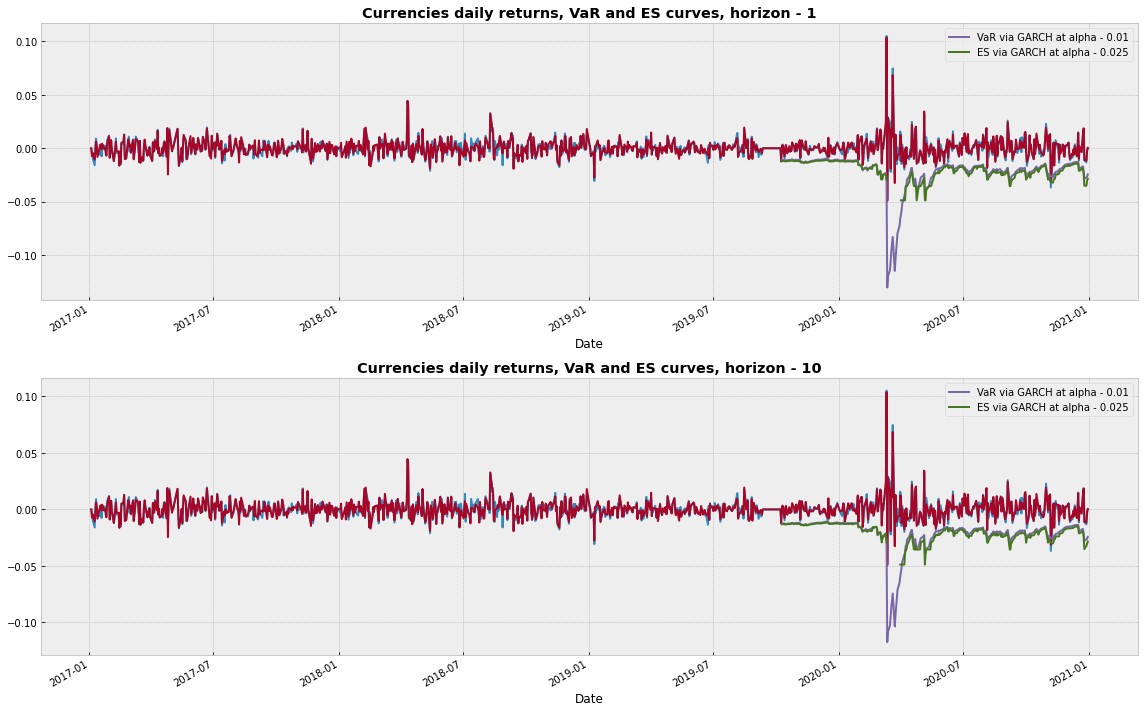

In [470]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(currencies_ret)
VaR_currencies_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_currencies_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Currencies daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(currencies_ret)
VaR_currencies_10.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_currencies_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Currencies daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_hist_GARCH(currencies_ret, 'currencies')

# Бектесты

In [188]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))


def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

Date
2017-01-04    0.000000
2017-01-05    0.000627
2017-01-06    0.000154
2017-01-09    0.000139
2017-01-10    0.000145
                ...   
2020-12-24   -0.000146
2020-12-25   -0.000046
2020-12-28    0.000083
2020-12-29    0.000191
2020-12-30    0.000034
Length: 1007, dtype: float64

In [192]:
# пример
backtest_results(
    rr.mean(axis=1), 
    var_curve=VaR,
    alpha=0.99, 
    significance=0.95
)

Target share of violations: 99.00%
Observed share of violations: 29.00%

Test for coverage isn't passed

Test for independence isn't passed


Для бектеста нескольких кривых одновременно.

In [ ]:
def backtest_results(ret, var_curves,curves_names, alpha, significance=0.95):
    for i, var_curve in enumerate(var_curves):
        idx = var_curve.notna()

        violations = ret[idx] < var_curve[idx]

        coverage = bern_test(p=alpha, v=violations) < chi2.ppf(significance, 1)
        independence = ind_test(violations) < chi2.ppf(significance, 1)
        
        print(curves_names[i] + ' results:')
        
        print('Target share of violations: {:.2f}%'.format(100*alpha))
        print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))

        print('')

        if coverage:
            print('Test for coverage is passed')
        else:
            print('Test for coverage isn\'t passed')

        print('')

        if independence:
            print('Test for independence is passed')
        else:
            print('Test for independence isn\'t passed')
            
        print('_'*40)


In [ ]:
# пример
backtest_results(
    ret, 
    var_curves=[VaR_HS_series, VaR_gennorm_series, VaR_GARCH_series, VaR_GARCH_EVT_series],
    curves_names = ['VaR_HS_series', 'VaR_gennorm_series', 'VaR_GARCH_series', 'VaR_GARCH_EVT_series'], 
    alpha=alpha, 
    significance=0.9
)